In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose

#### Data for 90 days

In [2]:
df = pd.read_csv('/Users/tammichia/Desktop/capstone eda/user_features_l90_labelled_20231111.csv')

#### Data for 270 days

In [3]:
train_data_n180d_daily_balance = pd.read_csv('/Users/tammichia/Desktop/capstone eda/train_data_n180d_daily_balance.csv')
dates = train_data_n180d_daily_balance["pt_date"].unique()
dates.sort()
print(f"Date range: {dates[0]} - {dates[-1]}")

Date range: 2023-03-01 - 2023-08-28


In [4]:
train_data_l90d_daily_balance = pd.read_csv('/Users/tammichia/Desktop/capstone eda/train_data_l90d_daily_balance.csv')
dates = train_data_l90d_daily_balance["pt_date"].unique()
dates.sort()
print(f"Date range: {dates[0]} - {dates[-1]}")

Date range: 2022-12-01 - 2023-03-01


#### Concatenating 90 days and 180 days for 270 days

In [5]:
train_data_l90d_daily_balance = train_data_l90d_daily_balance.drop(
    train_data_l90d_daily_balance[train_data_l90d_daily_balance["pt_date"] == "2023-03-01"].index
)
# for Feature Engineering
train_data_full_daily_balance = pd.concat([train_data_l90d_daily_balance, train_data_n180d_daily_balance])
#for Time Series Analysis
combined_df = pd.concat([train_data_l90d_daily_balance, train_data_n180d_daily_balance], ignore_index=True).drop_duplicates().sort_values(by=['user_id', 'pt_date'])
#for Individual-Portfolio Stability Correlation
train = pd.concat([train_data_l90d_daily_balance, train_data_n180d_daily_balance], ignore_index=True).drop_duplicates().sort_values(by=['user_id', 'pt_date'])

## Preliminary EDA (over 270 days)

#### Data Exploration

In [6]:
print(train_data_full_daily_balance.shape)
print(train_data_full_daily_balance.columns)

(13673034, 3)
Index(['pt_date', 'user_id', 'total_balance'], dtype='object')


In [7]:
# check for null values
train_data_full_daily_balance.isnull().sum().sort_values(ascending=False)

pt_date          0
user_id          0
total_balance    0
dtype: int64

In [8]:
# check the number of customers in the dataset
print(f'Number of customers: {len(train_data_full_daily_balance["user_id"].unique())}')
# check the range for the dates
dates = train_data_full_daily_balance["pt_date"].unique()
dates.sort()
print(f"Date range: {dates[0]} - {dates[-1]}")

Number of customers: 50454
Date range: 2022-12-01 - 2023-08-28


<Axes: xlabel='pt_date', ylabel='total_balance'>

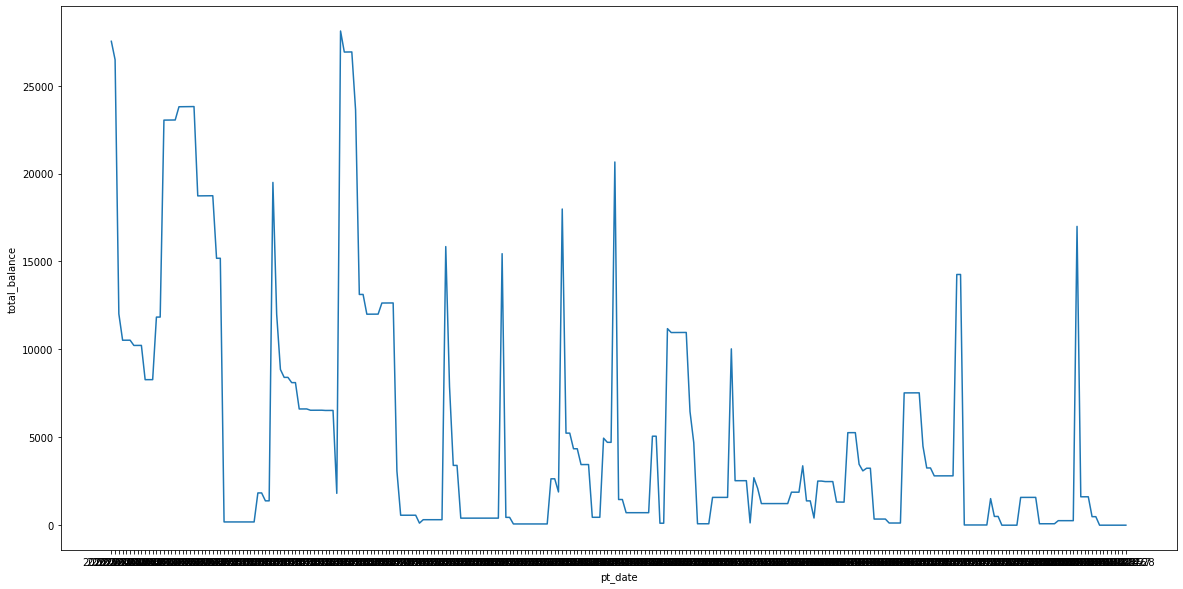

In [9]:
# investigating a particular user's bank balance
usr1 = train_data_full_daily_balance["user_id"].unique()[0]
usr1_df = train_data_full_daily_balance[train_data_full_daily_balance["user_id"] == usr1].sort_values(by="pt_date")
plt.figure(figsize=(20, 10))
sns.lineplot(usr1_df, x='pt_date', y='total_balance')

### EDA for Feature Engineering 
Features in the end (DIM table with user_id pk)
- label (based on first day balance)
- first day balance
- label (based on mean balance)
- mean balance
- growth
- volatility
- balance trend e.g. steady/increasing/decreasing (how to calculate)
- balance stability e.g. stable/volatile (how to calculate)
- number of actual transactions (must be a higher than a certain percentage of wealth)
- number of deposits (must be actual transaction first)
- number of withdrawals (must be actual transaction first)
- transactions per month

#### Absolute change in balance

In [10]:
train_data_full_daily_balance.sort_values(by=["user_id", "pt_date"], inplace=True)
train_data_full_daily_balance["abs_bal_change"] = train_data_full_daily_balance.groupby("user_id")["total_balance"].diff()
train_data_full_daily_balance.reset_index(drop=True, inplace=True)

Some of the changes in balance might be interest rate, based on a small sample size interest rate daily seems to be ~0.012% (these should not be treated as transactions)

#### Percentage change in balance

In [11]:
train_data_full_daily_balance["pct_bal_change"] = train_data_full_daily_balance.groupby("user_id")["total_balance"].pct_change() * 100

#### Segmentation by mean balance level

Text(0.5, 0, 'Average Balance')

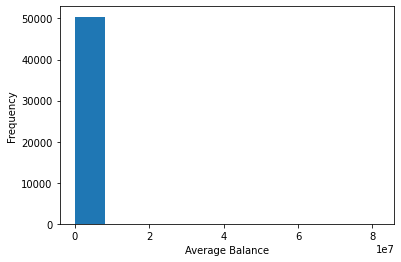

In [12]:
user_dim_table = train_data_full_daily_balance.groupby("user_id").agg(avg_balance = pd.NamedAgg(column="total_balance", aggfunc="mean"))
user_dim_table.reset_index(inplace=True)
user_dim_table.avg_balance.plot.hist()
plt.xlabel('Average Balance')

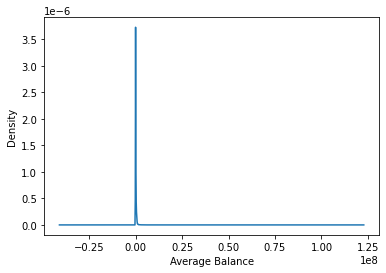

In [13]:
# Plot the density plot
density_plot = user_dim_table.avg_balance.plot.kde()
# Add labels and title
plt.xlabel('Average Balance')
plt.ylabel('Density')
plt.show()

Most of the people have a "low" amount of money in their bank accounts, with the exceptions of a few outliers

In [14]:
bins = [-1, 5000, 30000, 100000, 350000, 2000000, float('inf')]
labels = ['Small', 'Medium', 'Big', 'Wealth Banking', 'Privilege Banking', 'Privilege Reserve']
user_dim_table['label_by_avg_bal'] = pd.cut(user_dim_table['avg_balance'], bins=bins, labels=labels)

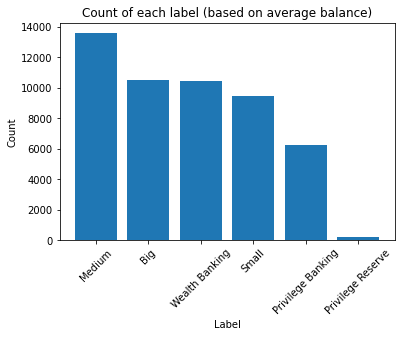

In [15]:
val_cnts = user_dim_table["label_by_avg_bal"].value_counts()
plt.bar(val_cnts.index, val_cnts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of each label (based on average balance)')
plt.xticks(rotation=45)
plt.show()

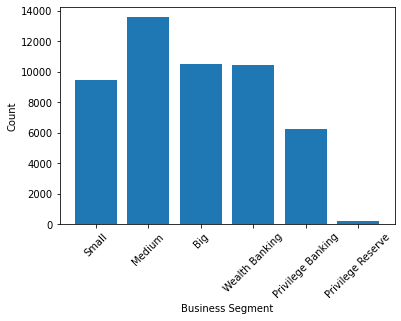

In [16]:
val_cnts = user_dim_table["label_by_avg_bal"].value_counts()

# Sort the values based on the custom order of labels
val_cnts = val_cnts.loc[labels]

# Plot the bar chart
plt.bar(val_cnts.index, val_cnts.values)

# Add labels and title
plt.xlabel('Business Segment')
plt.ylabel('Count')
#plt.title('Count of each label (based on average balance)')
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Segmentation by first day balance

<Axes: >

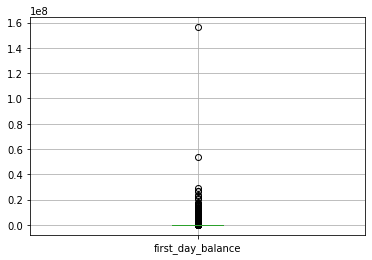

In [17]:
train_data_full_daily_balance[train_data_full_daily_balance["pt_date"] == '2022-12-01'][["user_id", "total_balance"]]
user_dim_table["first_day_balance"] = list(train_data_full_daily_balance[train_data_full_daily_balance["pt_date"] == '2022-12-01']["total_balance"])
user_dim_table.boxplot(column="first_day_balance")

In [18]:
Q1 = user_dim_table["first_day_balance"].quantile(.25)
Q2 = user_dim_table["first_day_balance"].quantile(.5)
Q3 = user_dim_table["first_day_balance"].quantile(.75)
Q4 = user_dim_table["first_day_balance"].quantile(.99)
print(f'25th percentile: {Q1}')
print(f'50th percentile: {Q2}')
print(f'75th percentile: {Q3}')
print(f'99th percentile: {Q4}')

25th percentile: 3957.92625
50th percentile: 34597.0875
75th percentile: 152832.37125
99th percentile: 1875307.459050002


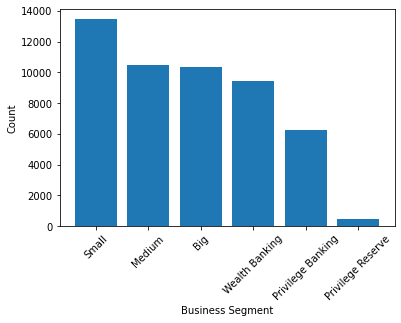

In [19]:
user_dim_table['label_by_first_bal'] = pd.cut(user_dim_table['first_day_balance'], bins=bins, labels=labels)
user_dim_table[['label_by_avg_bal', 'label_by_first_bal']].value_counts()
val_cnts = user_dim_table["label_by_first_bal"].value_counts()
plt.bar(val_cnts.index, val_cnts.values)
plt.xlabel('Business Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Total deposits per day (will be used to calculate alpha and beta)


In [20]:
agg_balance = train_data_full_daily_balance.groupby('pt_date').agg(
    total_balance = pd.NamedAgg(column='total_balance', aggfunc = "sum")
)
agg_balance.reset_index(inplace = True)

In [21]:
import time

In [22]:
def z_score_normalize(column):
    mean = column.mean()
    std = column.std()
    normalized_column = (column - mean) / std
    return normalized_column
start = time.time()
agg_balance['total_balance_normalized'] = z_score_normalize(agg_balance['total_balance'])
end = time.time()
print(end - start)

0.0010080337524414062


In [23]:
agg_balance_var = agg_balance['total_balance'].std() ** 2
agg_balance_var_normalized = agg_balance['total_balance_normalized'].std() ** 2

<Axes: xlabel='pt_date', ylabel='total_balance_normalized'>

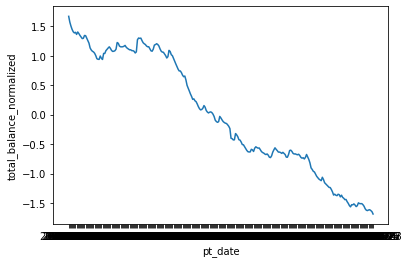

In [24]:
sns.lineplot(agg_balance, x='pt_date', y='total_balance_normalized')

#### Growth and Volatility

In [25]:
Y = agg_balance['total_balance']
Y_norm = agg_balance['total_balance_normalized']

user_id_list = []
growth_list = []
volatility_list = []
std_list = []
cv_list = []
abs_bal_change_mean_list = []
abs_bal_change_std_list = []
growth_coeff_list = []
beta_list = []
beta_normalized_list = []
correlation_list = []

row = 0
for user in train_data_full_daily_balance["user_id"].unique():
    # start = time.time()
    # user_df = train_data_l90d_daily_balance[train_data_l90d_daily_balance["user_id"] == user]
    user_df = train_data_full_daily_balance.iloc[row:row+271]
    row += 271

    # this from chatgpt, not sure if valid
    vol = user_df["pct_bal_change"].std()
    volatility_list.append(vol)

    stdev = user_df['total_balance'].std()
    std_list.append(stdev)

    cv = (stdev / user_df['total_balance'].mean()) * 100
    cv_list.append(cv)

    # find growth coeff
    x = list(range(0, 271))
    y = user_df["total_balance"]
    a, b = np.polyfit(x, y, 1)
    growth_coeff_list.append(a)
    
    growth = ((user_df['total_balance'].iloc[-1] - user_df['total_balance'].iloc[0]) / user_df['total_balance'].iloc[0]) * 100
    growth_list.append(growth)

    abs_bal_change_mean_list.append(user_df['abs_bal_change'].mean())
    abs_bal_change_std_list.append(user_df['abs_bal_change'].std())

    # calculate beta
    user_df.reset_index(inplace=True, drop=True)
    covariance = user_df['total_balance'].cov(Y)
    beta_list.append(covariance/agg_balance_var)
    
    # end = time.time()
    # print(end - start)

    # calculate beta but with normalized values
    # start = time.time()
    user_df = user_df[['total_balance']]
    user_df['total_balance_normalized'] = z_score_normalize(user_df['total_balance'])
    # user_df[['total_balance_normalized']] = scaler.fit_transform(user_df[['total_balance']])
    covariance_normalized = user_df['total_balance_normalized'].cov(Y_norm)
    beta_normalized_list.append(covariance_normalized/agg_balance_var_normalized)
    # end = time.time()
    # print(end - start)

    # # calculate correlation 
    # # start = time.time()
    correlation = user_df['total_balance'].corr(Y)
    correlation_list.append(correlation)
    # # end = time.time()
    # # print(end - start)
    
    user_id_list.append(user)

In [26]:
data = {
    'user_id': user_id_list,
    'growth': growth_list,
    'growth_coeff': growth_coeff_list,
    'volatility': volatility_list,
    'volatility_stdev': std_list,
    'volatility_cv': cv_list,
    'abs_bal_change_mean': abs_bal_change_mean_list,
    'abs_bal_change_std': abs_bal_change_std_list,
    'beta': beta_list,
    'beta_normalized': beta_normalized_list,
    'corr_coeff': correlation_list
}
df = pd.DataFrame(data)

In [27]:
user_dim_table = user_dim_table.merge(df, how='inner', left_on='user_id', right_on='user_id')

In [28]:
user_dim_table.isnull().sum()
# for those that have nan for growth (and not inf) it is because they start and end the cycle with 0 balance
# for those that have nan for volatility there is an inf for pct_bal_change due to user taking out all his money at some point and depositing any amount back in after

user_id                   0
avg_balance               0
label_by_avg_bal          0
first_day_balance         0
label_by_first_bal        0
growth                  271
growth_coeff              0
volatility             6200
volatility_stdev          0
volatility_cv             0
abs_bal_change_mean       0
abs_bal_change_std        0
beta                      0
beta_normalized           0
corr_coeff                0
dtype: int64

In [29]:
user_dim_table['growth'].fillna(0, inplace=True)

In [30]:
start = agg_balance.iloc[0]['total_balance']
end = agg_balance.iloc[-1]['total_balance']
benchmark_return = (end - start) / start

In [31]:
benchmark_return

-0.3394507315598034

#### Calculating alpha

In [32]:
user_dim_table['alpha'] = user_dim_table['growth'].apply(lambda x: None if x == np.inf else x - benchmark_return * 100)

#### Trend (based on line of best fit)

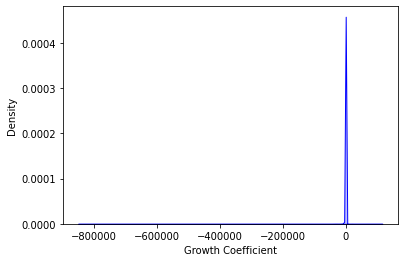

In [33]:
sns.kdeplot(user_dim_table['growth_coeff'], shade=True, color='blue')
# Add labels and title
plt.xlabel('Growth Coefficient')
plt.ylabel('Density')
# Show the plot
plt.show()

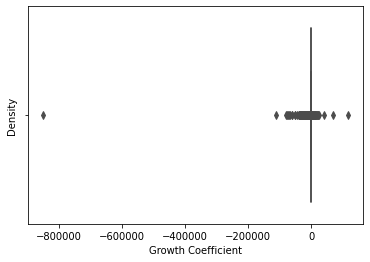

In [33]:
sns.boxplot(x=user_dim_table['growth_coeff'], color='blue')
# Add labels and title
plt.xlabel('Growth Coefficient')
plt.ylabel('Density')
# Show the plot
plt.show()

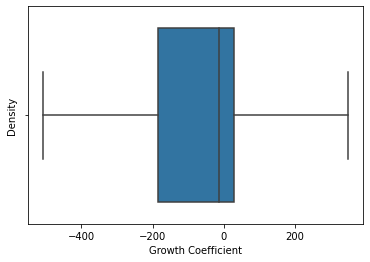

In [42]:
# Create the boxplot with whiskers
sns.boxplot(x=user_dim_table_no_outlier['growth_coeff'], showfliers=False, whis=1.5)

# Add labels and title
plt.xlabel('Growth Coefficient')
plt.ylabel('Density')

# Show the plot
plt.show()


In [72]:
Q1 = user_dim_table["growth_coeff"].quantile(.25)
Q2 = user_dim_table["growth_coeff"].quantile(.5)
Q3 = user_dim_table["growth_coeff"].quantile(.75)
Q4 = user_dim_table["growth_coeff"].quantile(.99)
print(f'Growth coefficient 25th percentile: {Q1}')
print(f'Growth coefficient 50th percentile: {Q2}')
print(f'Growth coefficient 75th percentile: {Q3}')
print(f'Growth coefficient 99th percentile: {Q4}')

Growth coefficient 25th percentile: -165.47099015990153
Growth coefficient 50th percentile: -8.424132927248397
Growth coefficient 75th percentile: 50.621627663519895
Growth coefficient 99th percentile: 1763.907022569641


In [73]:
trend_bins = [-float('inf'), -10, 10, float('inf')]
trend_labels = ['Decreasing', 'Stable', 'Increasing']
user_dim_table['trend'] = pd.cut(user_dim_table['growth_coeff'], bins=trend_bins, labels=trend_labels)

#### Number of Transactions

In [74]:
transactions = train_data_full_daily_balance[abs(train_data_full_daily_balance["pct_bal_change"]) > 0.015]
agg_transactions = transactions.groupby("user_id").agg(
    transactions = pd.NamedAgg(column="user_id", aggfunc="count")
)
agg_transactions.reset_index()

,user_id,transactions
0,0000102c03057f91c90faa1011e59870f2f8710597c27b...,189
1,0001c00642af4db4bfab49d3884b5e88f72acddc4cb03b...,12
2,0003c76e33adfa3484f6f8426d6f840cdaaade5bf71a2a...,32
3,0003e52fe559c035a21c6b38b6f16612a6689ea555480e...,171
4,0004d0051f38ca5c9df27bca501d556fd16fa9acd2df39...,52
...,...,...
47911,fff76a8dfb3e78fe545169ce8427012d783ab7f51e9fe1...,112
47912,fff798878bc2bb60ead2b2c405bc1c4bdc1b1ff713a422...,129
47913,fff7d14c2d27b7ba9c8c2e06940d38d17566b7ae04f208...,153
47914,fffae87c8a91a689bac61b5451f1f9887e681ccd723013...,212


In [75]:
deposits = transactions[transactions["pct_bal_change"] > 0]
agg_deposits = deposits.groupby("user_id").agg(
    deposits = pd.NamedAgg(column="user_id", aggfunc="count")
)
agg_deposits.reset_index()
agg_transactions = agg_transactions.merge(agg_deposits, how='left', left_on='user_id', right_on='user_id')
agg_transactions.reset_index(inplace = True)
agg_transactions["deposits"].fillna(0, inplace=True)
agg_transactions["deposits"] = agg_transactions["deposits"].astype(int)
agg_transactions["withdrawals"] = agg_transactions["transactions"] - agg_transactions["deposits"]

In [76]:
user_dim_table = user_dim_table.merge(agg_transactions, how="left", left_on="user_id", right_on="user_id")
lst = ["transactions", "deposits", "withdrawals"]
for col in lst:
    user_dim_table[col].fillna(0, inplace=True)
    user_dim_table[col] = user_dim_table[col].astype(int)

Text(0, 0.5, 'Frequency')

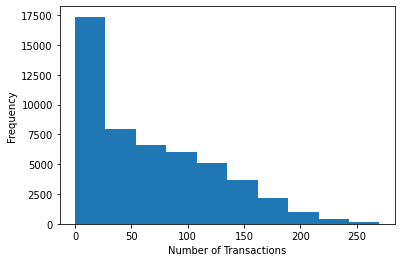

In [77]:
user_dim_table.transactions.plot.hist()
plt.xlabel("Number of Transactions")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

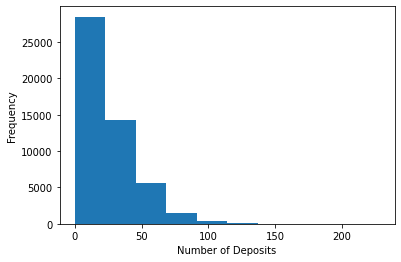

In [78]:
user_dim_table.deposits.plot.hist()
plt.xlabel("Number of Deposits")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

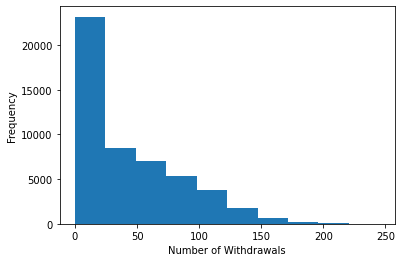

In [79]:
user_dim_table.withdrawals.plot.hist()
plt.xlabel("Number of Withdrawals")
plt.ylabel("Frequency")

#### Correlation Analysis

In [95]:
numeric_columns = user_dim_table.select_dtypes(include=['int32', 'float64'])
correlation = user_dim_table[list(numeric_columns)].corr()
correlation_styled = correlation.style.background_gradient(cmap='Greens').format("{:.2f}")
correlation_styled

,avg_balance,first_day_balance,growth,growth_coeff,volatility,volatility_stdev,volatility_cv,abs_bal_change_mean,abs_bal_change_std,beta,beta_normalized,corr_coeff,alpha
avg_balance,1.00,0.90,0.00,-0.64,-0.01,0.76,-0.15,-0.57,0.69,0.64,0.02,0.02,0.00
first_day_balance,0.90,1.00,-0.00,-0.84,-0.01,0.88,-0.07,-0.83,0.77,0.84,0.09,0.09,-0.00
growth,0.00,-0.00,1.00,0.00,0.06,0.00,0.00,0.01,0.00,-0.00,-0.02,-0.02,1.00
growth_coeff,-0.64,-0.84,0.00,1.00,0.00,-0.90,-0.01,0.92,-0.77,-1.00,-0.14,-0.14,0.00
volatility,-0.01,-0.01,0.06,0.00,1.00,0.00,0.07,0.00,0.02,-0.00,0.01,0.01,0.06
volatility_stdev,0.76,0.88,0.00,-0.90,0.00,1.00,-0.01,-0.77,0.92,0.90,0.07,0.07,0.00
volatility_cv,-0.15,-0.07,0.00,-0.01,0.07,-0.01,1.00,-0.02,0.02,0.01,0.24,0.24,0.00
abs_bal_change_mean,-0.57,-0.83,0.01,0.92,0.00,-0.77,-0.02,1.00,-0.63,-0.92,-0.15,-0.15,0.01
abs_bal_change_std,0.69,0.77,0.00,-0.77,0.02,0.92,0.02,-0.63,1.00,0.77,0.08,0.08,0.00
beta,0.64,0.84,-0.00,-1.00,-0.00,0.90,0.01,-0.92,0.77,1.00,0.14,0.14,-0.00


### Time Series Analysis

We conducted a time series analysis of the bank balance variations to understand the patterns and trends over time.

In [131]:
total_bank_balanced_combined_df = combined_df.groupby('pt_date').sum('total_balance')
total_bank_balanced_combined_df['SMA30'] = total_bank_balanced_combined_df['total_balance'].rolling(30).mean()
total_bank_balanced_combined_df['SMA7'] = total_bank_balanced_combined_df['total_balance'].rolling(7).mean()

<Axes: xlabel='pt_date'>

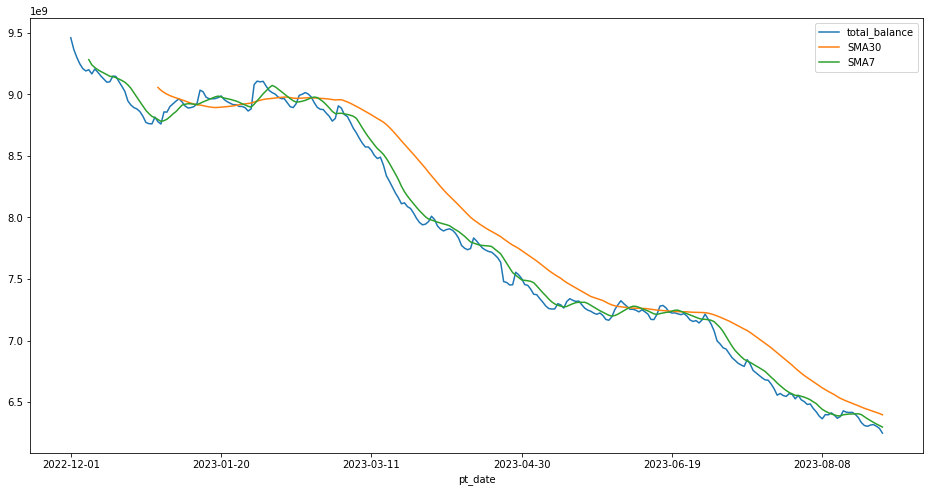

In [132]:
total_bank_balanced_combined_df[['total_balance', 'SMA30', 'SMA7']].plot(label='Overall portfolio',
                                  figsize=(16, 8))

The SMA here is calculated with a rolling window of 30 days which is moving average of the average overall portfolio desposits over a time period of 30 days. Both the SMA (orange) and overall portfolio deposits (blue) is on the downward trend. For most of the time, the overall portfolio deposits is consistently below the SMA line which indicates a strong downtrend pressure.



In [155]:
combined_df = combined_df.drop_duplicates(keep='first')
combined_df['pt_date'] = pd.to_datetime(combined_df['pt_date'])
combined_df.sort_values(by=['user_id', 'pt_date'], inplace=True)
combined_df['changes'] = combined_df.groupby('user_id')['total_balance'].diff().fillna(0)
combined_df['deposits'] = combined_df['changes'].apply(lambda x: x if x > 0 else 0)
combined_df['withdrawals'] = combined_df['changes'].apply(lambda x: abs(x) if x < 0 else 0)

In [156]:
df2 = combined_df.groupby('pt_date').agg({
    'total_balance': 'sum',
    'withdrawals': 'sum',
    'deposits': 'sum',
    'changes': 'sum',
}).reset_index()
df2['balance_increase_pct'] = np.log(df2['total_balance'] / df2['total_balance'].shift(1)) * 100

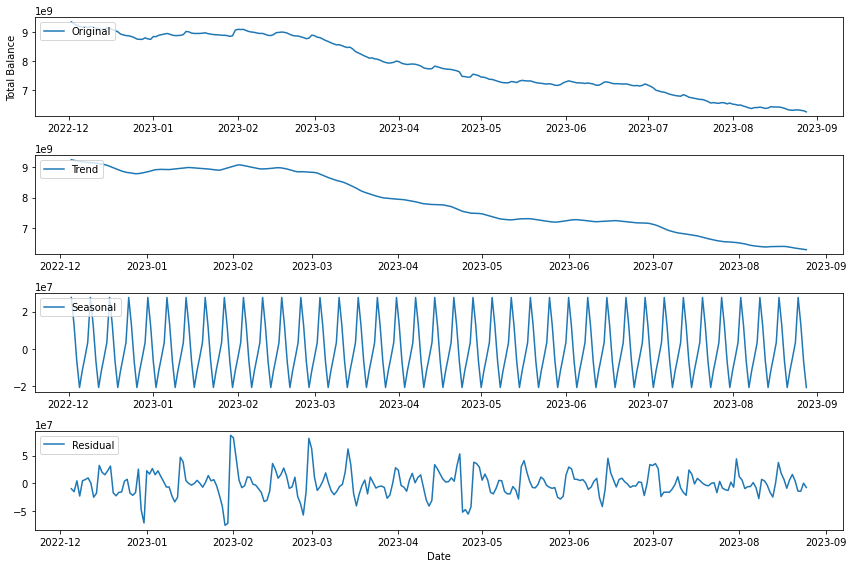

In [158]:
df2 = df2.dropna()
df2 = df2.set_index('pt_date')

# Perform STL decomposition
decomposition = sm.tsa.seasonal_decompose(df2['total_balance'], model='additive')

# Access the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))

# First subplot
plt.subplot(411)
plt.plot(df2['total_balance'], label='Original')
plt.legend(loc='upper left')
plt.ylabel('Total Balance')  # Add the y-axis label

# Second subplot
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')


# Third subplot
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')


# Fourth subplot
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.xlabel('Date')  # Add the x-axis label

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()

### Individual-Portfolio Stability Correlation 

We conducted EDA to explore the correlation of an individual and overall portfolio stability to understand how individual bank balance fluctuations contribute to overall portfolio stability. 


In [23]:
deposit_df = train.copy()
deposit_df['daily_balance_change'] = deposit_df.groupby('user_id')['total_balance'].diff().fillna(0)
deposit_df['daily_growth_rate'] = deposit_df.groupby('user_id')['total_balance'].pct_change().fillna(0)
test = train.merge(deposit_df[['user_id', 'pt_date', 'daily_balance_change']], on=['user_id', 'pt_date'], how='left')

In [24]:
result = test.groupby('user_id').agg( balance_change_std=('total_balance', 'std'),
                                     total_balance_mean=('total_balance', 'mean'),
                                    ).reset_index()

# Using coefficient of variation (CV) as indication of individual variability
# Higher stability = lower CV
result['coefficient_of_variation'] = result['balance_change_std'] / result['total_balance_mean']

# Ensure CV value is between 0 and 1
result['coefficient_of_variation_scaled'] = (result['coefficient_of_variation'] - min(result['coefficient_of_variation'])) / (max(result['coefficient_of_variation']) - min(result['coefficient_of_variation']))

# This approach ensures that the stability index remains bounded between 0 and 1 while still capturing the concept of stability. 
# It provides a smoother transition as CV values change and doesn't reach infinity.
# 1/CV will cause stability index to reach infinity for small values of CV
# result['indiv_stability'] = 1/(1+result['coefficient_of_variation'])
# result['log_indiv_stability'] = np.log(result['indiv_stability'])
result['indiv_stability'] = 1 - result['coefficient_of_variation_scaled']

# Contribution of indiv's avg balance to portfolio's avg balance
result['weight'] = result['total_balance_mean'] / np.mean(train.groupby('pt_date')['total_balance'].sum())

result['weighted_stability'] = result['weight'] * result['indiv_stability']
result

,user_id,balance_change_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability
0,0000102c03057f91c90faa1011e59870f2f8710597c27b...,53159.070330,52096.087860,1.020404,0.084125,0.915875,6.626495e-06,6.069041e-06
1,0001c00642af4db4bfab49d3884b5e88f72acddc4cb03b...,4744.732504,6123.607417,0.774826,0.063869,0.936131,7.789078e-07,7.291601e-07
2,0003c76e33adfa3484f6f8426d6f840cdaaade5bf71a2a...,5648.221080,9218.726125,0.612690,0.050495,0.949505,1.172599e-06,1.113389e-06
3,0003e52fe559c035a21c6b38b6f16612a6689ea555480e...,4506.440957,3100.786550,1.453322,0.119834,0.880166,3.944124e-07,3.471484e-07
4,0004d0051f38ca5c9df27bca501d556fd16fa9acd2df39...,21094.126913,23998.978616,0.878959,0.072458,0.927542,3.052611e-06,2.831425e-06
...,...,...,...,...,...,...,...,...
50449,fff76a8dfb3e78fe545169ce8427012d783ab7f51e9fe1...,8621.871263,7716.611679,1.117313,0.092118,0.907882,9.815341e-07,8.911167e-07
50450,fff798878bc2bb60ead2b2c405bc1c4bdc1b1ff713a422...,41320.327537,25398.253450,1.626896,0.134151,0.865849,3.230596e-06,2.797207e-06
50451,fff7d14c2d27b7ba9c8c2e06940d38d17566b7ae04f208...,22639.683788,50666.533284,0.446837,0.036814,0.963186,6.444659e-06,6.207402e-06
50452,fffae87c8a91a689bac61b5451f1f9887e681ccd723013...,136635.582329,206728.201162,0.660943,0.054475,0.945525,2.629532e-05,2.486288e-05


In [25]:
Q1 = result['total_balance_mean'].quantile(0.25)
Q3 = result['total_balance_mean'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_result = result[(result['total_balance_mean'] >= lower_bound) & (result['total_balance_mean'] <= upper_bound)]
outliers = result[(result['total_balance_mean'] < lower_bound) | (result['total_balance_mean'] > upper_bound)]

In [26]:
filtered_result

,user_id,balance_change_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability
0,0000102c03057f91c90faa1011e59870f2f8710597c27b...,53159.070330,52096.087860,1.020404,0.084125,0.915875,6.626495e-06,6.069041e-06
1,0001c00642af4db4bfab49d3884b5e88f72acddc4cb03b...,4744.732504,6123.607417,0.774826,0.063869,0.936131,7.789078e-07,7.291601e-07
2,0003c76e33adfa3484f6f8426d6f840cdaaade5bf71a2a...,5648.221080,9218.726125,0.612690,0.050495,0.949505,1.172599e-06,1.113389e-06
3,0003e52fe559c035a21c6b38b6f16612a6689ea555480e...,4506.440957,3100.786550,1.453322,0.119834,0.880166,3.944124e-07,3.471484e-07
4,0004d0051f38ca5c9df27bca501d556fd16fa9acd2df39...,21094.126913,23998.978616,0.878959,0.072458,0.927542,3.052611e-06,2.831425e-06
...,...,...,...,...,...,...,...,...
50449,fff76a8dfb3e78fe545169ce8427012d783ab7f51e9fe1...,8621.871263,7716.611679,1.117313,0.092118,0.907882,9.815341e-07,8.911167e-07
50450,fff798878bc2bb60ead2b2c405bc1c4bdc1b1ff713a422...,41320.327537,25398.253450,1.626896,0.134151,0.865849,3.230596e-06,2.797207e-06
50451,fff7d14c2d27b7ba9c8c2e06940d38d17566b7ae04f208...,22639.683788,50666.533284,0.446837,0.036814,0.963186,6.444659e-06,6.207402e-06
50452,fffae87c8a91a689bac61b5451f1f9887e681ccd723013...,136635.582329,206728.201162,0.660943,0.054475,0.945525,2.629532e-05,2.486288e-05


In [27]:
outliers

,user_id,balance_change_std,total_balance_mean,coefficient_of_variation,coefficient_of_variation_scaled,indiv_stability,weight,weighted_stability
7,00060282f7e4c96b7e4028124b9f11ce0fcdc6e5410310...,1.920418e+04,8.678647e+05,0.022128,0.001783,0.998217,0.000110,0.000110
11,000c5416da5e0199c02ecf2d7ef7fcbf6702121a337e86...,1.196638e+06,1.362010e+06,0.878583,0.072427,0.927573,0.000173,0.000161
19,001a715b939bf433a617647d07260598c4325f993c9568...,6.783921e+04,5.899459e+05,0.114992,0.009442,0.990558,0.000075,0.000074
45,003dfb77f8a1522e68ae42a0771bd43cf50124a6bcde7f...,2.338280e+05,5.394359e+05,0.433468,0.035712,0.964288,0.000069,0.000066
55,0049f69c8df541e2187e78a88a6e2a2f1b556454e2cadc...,1.952890e+05,5.390951e+05,0.362253,0.029838,0.970162,0.000069,0.000067
...,...,...,...,...,...,...,...,...
50350,ff879b4fa182a8567fbc05a52a682ec45bb6a60b8adee0...,3.445522e+05,1.395758e+06,0.246857,0.020319,0.979681,0.000178,0.000174
50372,ffa91c163610b1e6663612e507ebdb73f5e5e41fe9731e...,1.374168e+05,4.044569e+05,0.339756,0.027982,0.972018,0.000051,0.000050
50375,ffae450374548982f2d1584edc23cb88a7a4ce0c3947ae...,9.626371e+04,7.183052e+05,0.134015,0.011012,0.988988,0.000091,0.000090
50384,ffbab240f211a46c0ac9cfd636d06122acea7cdab979d0...,6.093300e+04,6.600878e+05,0.092310,0.007572,0.992428,0.000084,0.000083


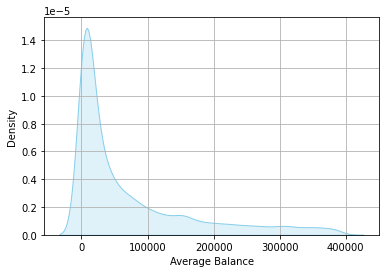

In [28]:
# Create a density plot of total_balance_mean
sns.kdeplot(data=filtered_result, x='total_balance_mean', fill=True, color='skyblue')

plt.xlabel('Average Balance')
plt.ylabel('Density')
#plt.title("Density Plot of Individual's Average Balance (w/o Outliers)")
plt.grid(True)
plt.show()

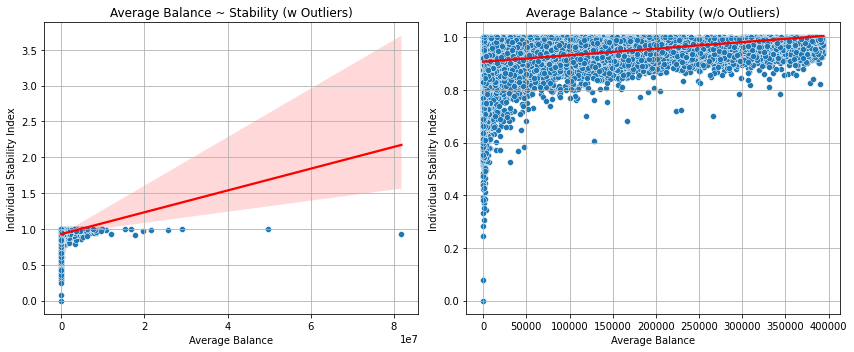

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the second scatter plot
sns.scatterplot(data=result, x='total_balance_mean', y='indiv_stability', ax=axes[0])
sns.regplot(data=result, x='total_balance_mean', y='indiv_stability', scatter=False, color='red', ax=axes[0])
axes[0].set_xlabel('Average Balance')
axes[0].set_ylabel('Individual Stability Index')
axes[0].set_title('Average Balance ~ Stability (w Outliers)')
axes[0].grid(True)


# Plot the second scatter plot
sns.scatterplot(data=filtered_result, x='total_balance_mean', y='indiv_stability', ax=axes[1])
sns.regplot(data=filtered_result, x='total_balance_mean', y='indiv_stability', scatter=False, color='red', ax=axes[1])
axes[1].set_xlabel('Average Balance')
axes[1].set_ylabel('Individual Stability Index')
axes[1].set_title('Average Balance ~ Stability (w/o Outliers)')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### Pearson Correlation Coefficient 

In [107]:
correlation_f = filtered_result['weight'].corr(filtered_result['indiv_stability'])
correlation_f

0.3748474214322107

In [108]:
correlation = result['weight'].corr(result['indiv_stability'])
correlation

0.1487980821337538

In this context, a positive correlation suggests that users with higher average total balances (and hence higher weights) may, on average, have slightly higher relative stability in their balances (i.e., lower coefficient of variation). This could imply that users with more substantial average balances tend to maintain more stable or consistent balances over time. Even more so because positive correlation became stronger after outlier handling i.e., main customer group (non-outliers) display this association as well.

In [109]:
def generate_customer_group_total_daily_balance(indiv_stability_p_lb, indiv_stability_p_ub):
    is_p = pd.DataFrame()

    is_p = result[(result['indiv_stability'] >= np.percentile(result['indiv_stability'], indiv_stability_p_lb)) \
                  & (result['indiv_stability'] < np.percentile(result['indiv_stability'], indiv_stability_p_ub))]
        
    is_p_users = is_p['user_id'].unique()
    train_is_p = train[train['user_id'].isin(is_p_users)]
    
    new_col_name = 'is_' + str(indiv_stability_p_lb) + 'p_' + str(indiv_stability_p_ub) + 'p_total_balance'
    total_daily_balance = train_is_p.groupby('pt_date')['total_balance'].sum().reset_index().rename(
        columns={'total_balance': new_col_name})
    
    return total_daily_balance

In [110]:
def generate_customer_group_total_daily_balance_mean(indiv_stability_p_lb, indiv_stability_p_ub):
    is_p = pd.DataFrame()

    is_p = result[(result['total_balance_mean'] >= np.percentile(result['total_balance_mean'], indiv_stability_p_lb)) \
                  & (result['total_balance_mean'] < np.percentile(result['total_balance_mean'], indiv_stability_p_ub))]
        
    is_p_users = is_p['user_id'].unique()
    train_is_p = train[train['user_id'].isin(is_p_users)]
    
    new_col_name = 'is_' + str(indiv_stability_p_lb) + 'p_' + str(indiv_stability_p_ub) + 'p_total_balance_mean'
    total_daily_balance = train_is_p.groupby('pt_date')['total_balance'].sum().reset_index().rename(
        columns={'total_balance': new_col_name})
    
    return total_daily_balance

In [111]:
is_0p_10p_bal = generate_customer_group_total_daily_balance(0,10)
is_10p_20p_bal = generate_customer_group_total_daily_balance(10,20)
is_20p_30p_bal = generate_customer_group_total_daily_balance(20,30)
is_30p_40p_bal = generate_customer_group_total_daily_balance(30,40)
is_40p_50p_bal = generate_customer_group_total_daily_balance(40,50)
is_50p_60p_bal = generate_customer_group_total_daily_balance(50,60)
is_60p_70p_bal = generate_customer_group_total_daily_balance(60,70)
is_70p_80p_bal = generate_customer_group_total_daily_balance(70,80)
is_80p_90p_bal = generate_customer_group_total_daily_balance(80,90)
is_90p_100p_bal = generate_customer_group_total_daily_balance(90,100)

In [112]:
is_0p_10p_bal_m = generate_customer_group_total_daily_balance_mean(0,10)
is_10p_20p_bal_m = generate_customer_group_total_daily_balance_mean(10,20)
is_20p_30p_bal_m = generate_customer_group_total_daily_balance_mean(20,30)
is_30p_40p_bal_m = generate_customer_group_total_daily_balance_mean(30,40)
is_40p_50p_bal_m = generate_customer_group_total_daily_balance_mean(40,50)
is_50p_60p_bal_m = generate_customer_group_total_daily_balance_mean(50,60)
is_60p_70p_bal_m = generate_customer_group_total_daily_balance_mean(60,70)
is_70p_80p_bal_m = generate_customer_group_total_daily_balance_mean(70,80)
is_80p_90p_bal_m = generate_customer_group_total_daily_balance_mean(80,90)
is_90p_100p_bal_m = generate_customer_group_total_daily_balance_mean(90,100)

In [113]:
is_0p_70p_bal_m = generate_customer_group_total_daily_balance_mean(0,70)
is_70p_100p_bal_m = generate_customer_group_total_daily_balance_mean(70,100)

In [114]:
is_0p_80p_bal = generate_customer_group_total_daily_balance(0,80)
is_0p_90p_bal = generate_customer_group_total_daily_balance(0,90)
is_80p_100p_bal = generate_customer_group_total_daily_balance(80,100)

In [116]:
portfolio_daily_balance = train.groupby('pt_date')['total_balance']\
.sum().reset_index().rename(columns={'total_balance': 'portfolio_total_balance'})

In [117]:
dfs = [portfolio_daily_balance,
      is_0p_10p_bal,
      is_10p_20p_bal,
      is_20p_30p_bal,
      is_30p_40p_bal,
      is_40p_50p_bal,
      is_50p_60p_bal,
      is_60p_70p_bal,
      is_70p_80p_bal,
      is_80p_90p_bal,
      is_90p_100p_bal, 
       
       is_0p_80p_bal,
       is_0p_90p_bal,
       is_80p_100p_bal,
       

       is_0p_10p_bal_m,
      is_10p_20p_bal_m,
      is_20p_30p_bal_m,
      is_30p_40p_bal_m,
      is_40p_50p_bal_m,
      is_50p_60p_bal_m,
      is_60p_70p_bal_m,
      is_70p_80p_bal_m,
      is_80p_90p_bal_m,
      is_90p_100p_bal_m,
       
       is_0p_70p_bal_m,
       is_70p_100p_bal_m
      ]

df = dfs[0]

for d in dfs[1:]:
    df = pd.merge(df, d, on='pt_date')

df

,pt_date,portfolio_total_balance,is_0p_10p_total_balance,is_10p_20p_total_balance,is_20p_30p_total_balance,is_30p_40p_total_balance,is_40p_50p_total_balance,is_50p_60p_total_balance,is_60p_70p_total_balance,is_70p_80p_total_balance,...,is_20p_30p_total_balance_mean,is_30p_40p_total_balance_mean,is_40p_50p_total_balance_mean,is_50p_60p_total_balance_mean,is_60p_70p_total_balance_mean,is_70p_80p_total_balance_mean,is_80p_90p_total_balance_mean,is_90p_100p_total_balance_mean,is_0p_70p_total_balance_mean,is_70p_100p_total_balance_mean
0,2022-12-01,9.459402e+09,3.917748e+08,4.558119e+08,6.212578e+08,8.538412e+08,7.744932e+08,9.299176e+08,1.064254e+09,1.309496e+09,...,7.104960e+07,1.232134e+08,2.011617e+08,3.258066e+08,5.189088e+08,8.598139e+08,1.695456e+09,5.463359e+09,1.284561e+09,8.018629e+09
1,2022-12-02,9.364988e+09,3.740369e+08,4.490067e+08,6.010097e+08,8.362507e+08,7.616701e+08,9.197670e+08,1.057797e+09,1.306034e+09,...,6.879284e+07,1.220522e+08,1.998546e+08,3.233422e+08,5.089768e+08,8.470367e+08,1.658292e+09,5.437962e+09,1.265469e+09,7.943290e+09
2,2022-12-03,9.300850e+09,3.617710e+08,4.338914e+08,5.927707e+08,8.283440e+08,7.568466e+08,9.118657e+08,1.052816e+09,1.304676e+09,...,6.514439e+07,1.200566e+08,1.973836e+08,3.164359e+08,5.010112e+08,8.348519e+08,1.645325e+09,5.423906e+09,1.240603e+09,7.904082e+09
3,2022-12-04,9.247724e+09,3.541581e+08,4.249836e+08,5.886632e+08,8.184120e+08,7.488130e+08,9.069735e+08,1.046813e+09,1.300760e+09,...,6.225319e+07,1.170561e+08,1.934651e+08,3.102880e+08,4.957362e+08,8.305416e+08,1.639132e+09,5.404923e+09,1.216945e+09,7.874596e+09
4,2022-12-05,9.209176e+09,3.532545e+08,4.209899e+08,5.798598e+08,8.085404e+08,7.425206e+08,9.019980e+08,1.041835e+09,1.299137e+09,...,6.134264e+07,1.147975e+08,1.912126e+08,3.080426e+08,4.897011e+08,8.254452e+08,1.630916e+09,5.395029e+09,1.201587e+09,7.851391e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2023-08-24,6.313775e+09,4.363287e+07,9.067810e+07,1.434701e+08,2.892172e+08,3.206274e+08,4.684053e+08,7.330199e+08,1.135627e+09,...,3.110564e+07,6.084883e+07,1.185192e+08,2.262427e+08,4.009125e+08,7.395147e+08,1.258111e+09,3.460727e+09,8.551705e+08,5.458353e+09
267,2023-08-25,6.318009e+09,4.417881e+07,9.596049e+07,1.445776e+08,2.929016e+08,3.230439e+08,4.640621e+08,7.327887e+08,1.134617e+09,...,3.207860e+07,6.337286e+07,1.208100e+08,2.290878e+08,4.050908e+08,7.376227e+08,1.259274e+09,3.452261e+09,8.686762e+08,5.449157e+09
268,2023-08-26,6.304411e+09,4.183219e+07,9.554824e+07,1.446727e+08,2.927267e+08,3.213975e+08,4.618826e+08,7.315438e+08,1.130912e+09,...,3.105718e+07,6.234104e+07,1.210892e+08,2.275984e+08,4.030296e+08,7.376383e+08,1.256845e+09,3.446832e+09,8.629187e+08,5.441316e+09
269,2023-08-27,6.287521e+09,4.189468e+07,9.391197e+07,1.426963e+08,2.906655e+08,3.188634e+08,4.605835e+08,7.287166e+08,1.128244e+09,...,3.075609e+07,6.168552e+07,1.208691e+08,2.269046e+08,4.013569e+08,7.328765e+08,1.252836e+09,3.442898e+09,8.587339e+08,5.428610e+09


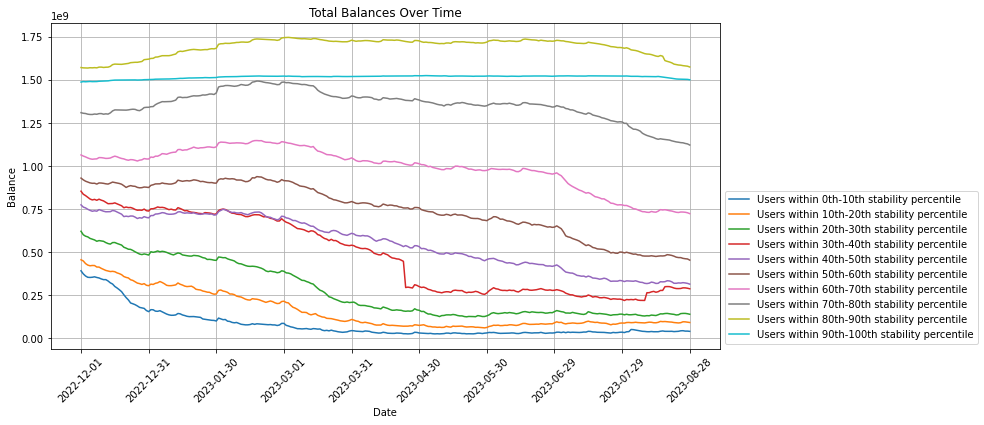

In [118]:
plt.figure(figsize=(12, 6))

# Plot the lines for each column
# plt.plot(df['pt_date'], df['portfolio_total_balance'], label='Portfolio Total Balance')
plt.plot(df['pt_date'], df['is_0p_10p_total_balance'], label='Users within 0th-10th stability percentile')
plt.plot(df['pt_date'], df['is_10p_20p_total_balance'], label='Users within 10th-20th stability percentile')
plt.plot(df['pt_date'], df['is_20p_30p_total_balance'], label='Users within 20th-30th stability percentile')
plt.plot(df['pt_date'], df['is_30p_40p_total_balance'], label='Users within 30th-40th stability percentile')
plt.plot(df['pt_date'], df['is_40p_50p_total_balance'], label='Users within 40th-50th stability percentile')
plt.plot(df['pt_date'], df['is_50p_60p_total_balance'], label='Users within 50th-60th stability percentile')
plt.plot(df['pt_date'], df['is_60p_70p_total_balance'], label='Users within 60th-70th stability percentile')
plt.plot(df['pt_date'], df['is_70p_80p_total_balance'], label='Users within 70th-80th stability percentile')
plt.plot(df['pt_date'], df['is_80p_90p_total_balance'], label='Users within 80th-90th stability percentile')
plt.plot(df['pt_date'], df['is_90p_100p_total_balance'], label='Users within 90th-100th stability percentile')

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Total Balances Over Time')
plt.xticks(np.arange(0, len(portfolio_daily_balance['pt_date']), 30), rotation=45)  # Rotate x-axis labels for better readability

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.grid(True)
plt.show()

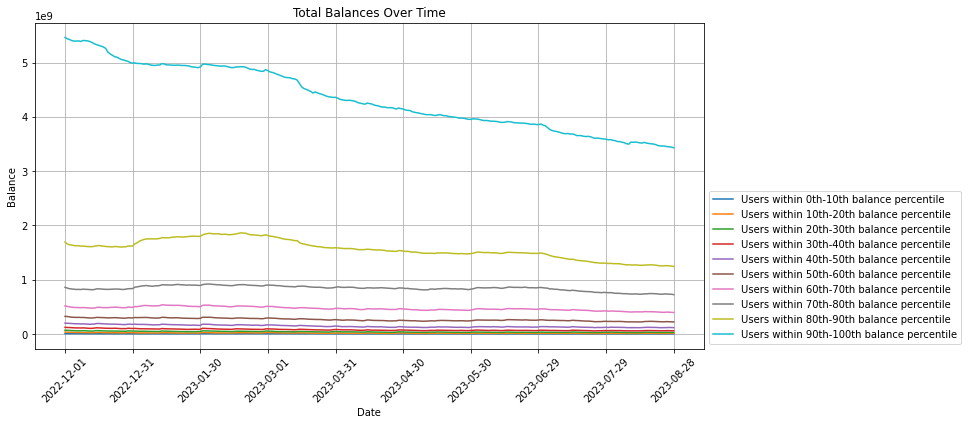

In [119]:
plt.figure(figsize=(12, 6))

# Plot the lines for each column
# plt.plot(df['pt_date'], df['portfolio_total_balance'], label='Portfolio Total Balance')
plt.plot(df['pt_date'], df['is_0p_10p_total_balance_mean'], label='Users within 0th-10th balance percentile')
plt.plot(df['pt_date'], df['is_10p_20p_total_balance_mean'], label='Users within 10th-20th balance percentile')
plt.plot(df['pt_date'], df['is_20p_30p_total_balance_mean'], label='Users within 20th-30th balance percentile')
plt.plot(df['pt_date'], df['is_30p_40p_total_balance_mean'], label='Users within 30th-40th balance percentile')
plt.plot(df['pt_date'], df['is_40p_50p_total_balance_mean'], label='Users within 40th-50th balance percentile')
plt.plot(df['pt_date'], df['is_50p_60p_total_balance_mean'], label='Users within 50th-60th balance percentile')
plt.plot(df['pt_date'], df['is_60p_70p_total_balance_mean'], label='Users within 60th-70th balance percentile')
plt.plot(df['pt_date'], df['is_70p_80p_total_balance_mean'], label='Users within 70th-80th balance percentile')
plt.plot(df['pt_date'], df['is_80p_90p_total_balance_mean'], label='Users within 80th-90th balance percentile')
plt.plot(df['pt_date'], df['is_90p_100p_total_balance_mean'], label='Users within 90th-100th balance percentile')

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Total Balances Over Time')
plt.xticks(np.arange(0, len(portfolio_daily_balance['pt_date']), 30), rotation=45)  # Rotate x-axis labels for better readability

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.grid(True)
plt.show()

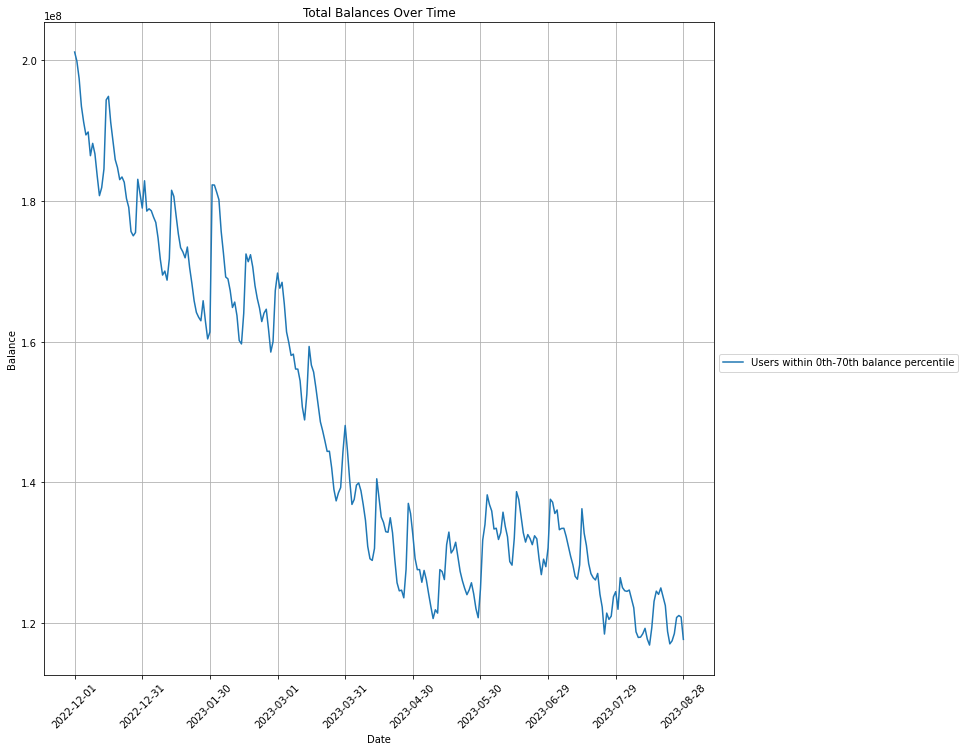

In [120]:
plt.figure(figsize=(12, 12))

# Plot the lines for each column
# plt.plot(df['pt_date'], df['portfolio_total_balance'], label='Portfolio Total Balance')
plt.plot(df['pt_date'], df['is_40p_50p_total_balance_mean'], label='Users within 0th-70th balance percentile')
# plt.plot(df['pt_date'], df['is_70p_100p_total_balance_mean'], label='Users within 70th-100th balance percentile')

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Total Balances Over Time')
plt.xticks(np.arange(0, len(portfolio_daily_balance['pt_date']), 30), rotation=45)  # Rotate x-axis labels for better readability

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.grid(True)
plt.show()

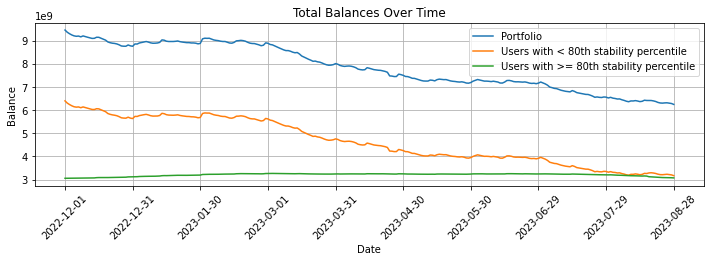

In [121]:
plt.figure(figsize=(12, 3))

# Plot the lines for each column
plt.plot(df['pt_date'], df['portfolio_total_balance'], label='Portfolio')
plt.plot(df['pt_date'], df['is_0p_80p_total_balance'], label='Users with < 80th stability percentile')
plt.plot(df['pt_date'], df['is_80p_100p_total_balance'], label='Users with >= 80th stability percentile')

# Set labels for the axes and the legend
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Total Balances Over Time')
plt.xticks(np.arange(0, len(portfolio_daily_balance['pt_date']), 30), rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

#### Spearman Correlation Coefficient and p-value

In [124]:
spearman_corr, p_value = spearmanr(df['is_80p_100p_total_balance'], df['portfolio_total_balance'])
print("Spearman Correlation Coefficient and p-value:", spearman_corr, p_value)

spearman_corr, p_value = spearmanr(df['is_0p_80p_total_balance'], df['portfolio_total_balance'])
print("Spearman Correlation Coefficient and p-value:", spearman_corr, p_value)

Spearman Correlation Coefficient and p-value: -0.08475086221450451 0.16415554489466797
Spearman Correlation Coefficient and p-value: 0.9943901791959097 1.766795968870252e-264


## Secondary EDA (over 90 Days) 

We conducted EDA on the existing and newly created features to uncover differences in the distributions of the neither, subset and growth classes, to discover potentially useful features for our classification models.

Numerical Features: 
- avg_balance
- growth_coeff
- volatility_stdev
- volatility_cv
- abs_bal_change_mean
- abs_bal_change_std
- beta_normalized
- transactions
- deposits
- withdrawals
- withdrawal_propn
- deposit_propn
- stability_index
- ema_7day
- ema_20day
- ema_50day
- ema_90day
- num_distinct_recurring_tx
- num_ema_crosses

Categorical Features:
- trend
- stat_sig_positive_kendall
- stationary
- recurring_transactions
- recurring_deposits
- recurring_withdrawals
- income
- subscription
- micro_savings
- label_by_avg_bal

### Numerical Features (neither vs. growth vs. stable)

In [102]:
numerical_features = ['avg_balance', 'growth_coeff', 'volatility_stdev', 'volatility_cv', 
                      'abs_bal_change_mean', 'abs_bal_change_std', 'beta_normalized', 
                      'transactions', 'deposits', 'withdrawals', 'withdrawal_propn',
                      'deposit_propn','stability_index', 'ema_7day', 'ema_20day', 'ema_50day', 
                      'ema_90day','num_distinct_recurring_tx', 'num_ema_crosses']

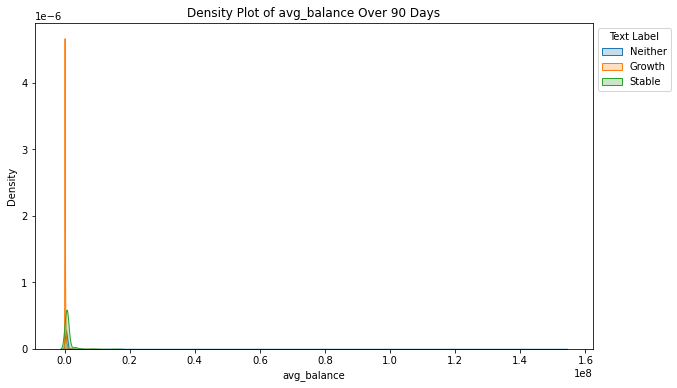

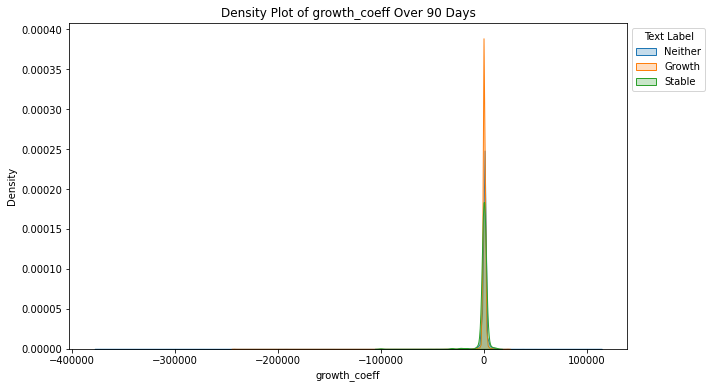

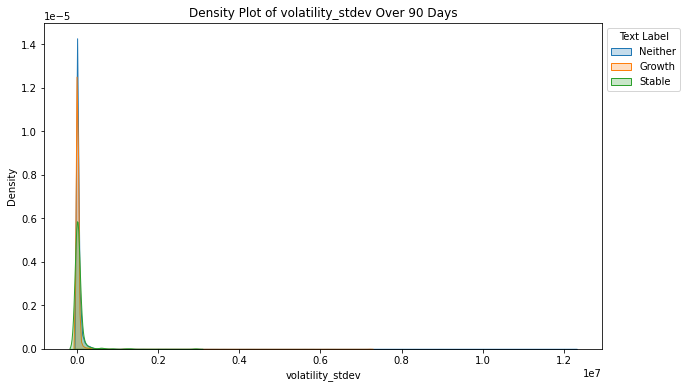

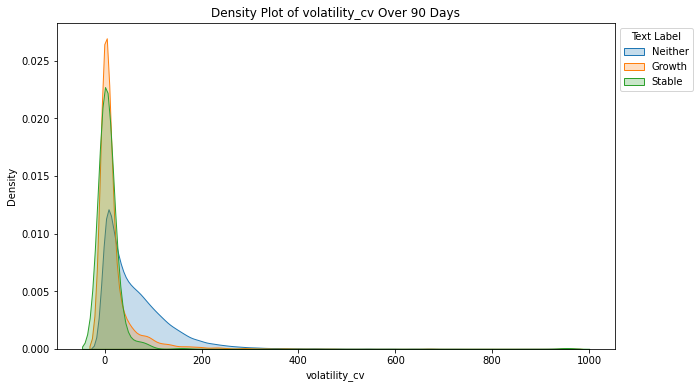

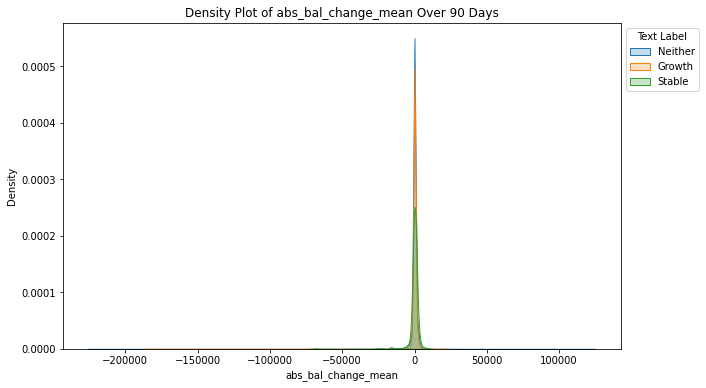

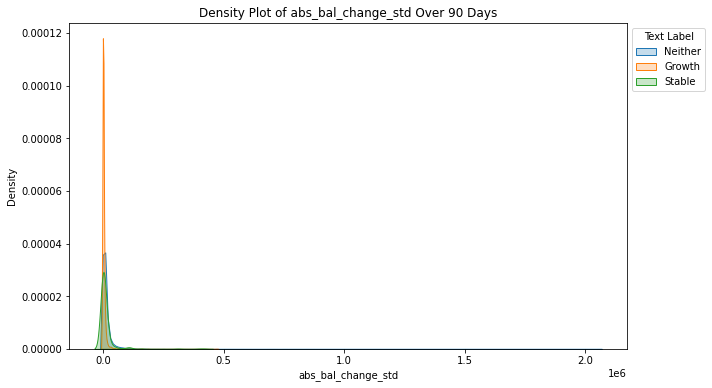

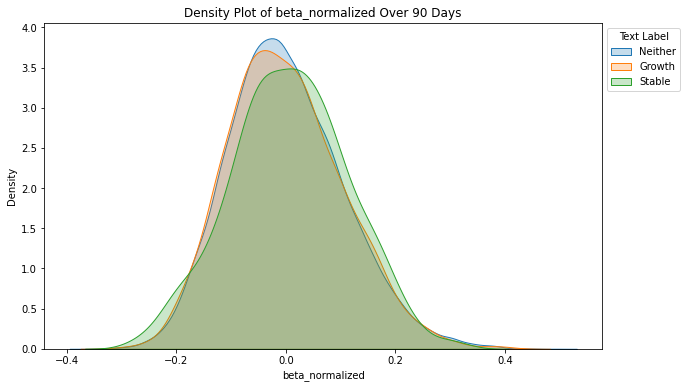

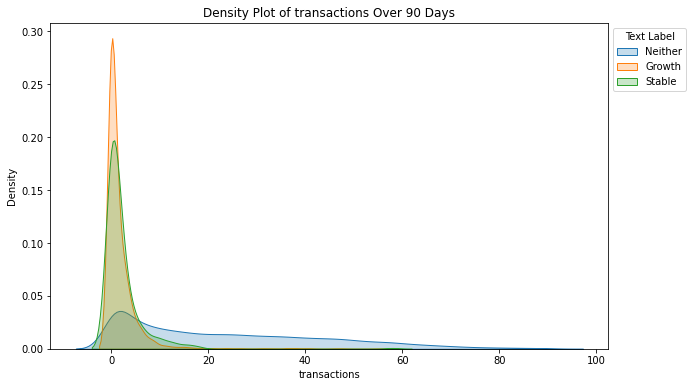

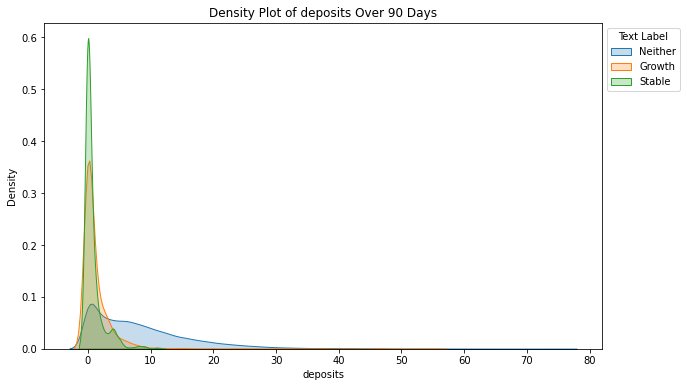

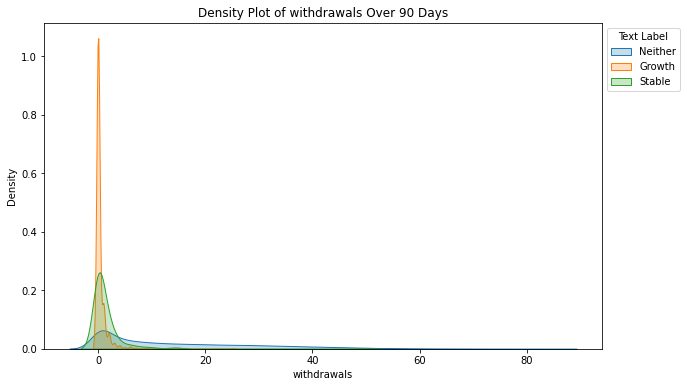

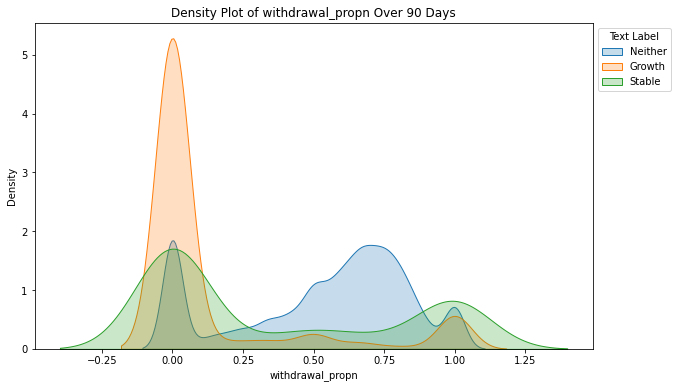

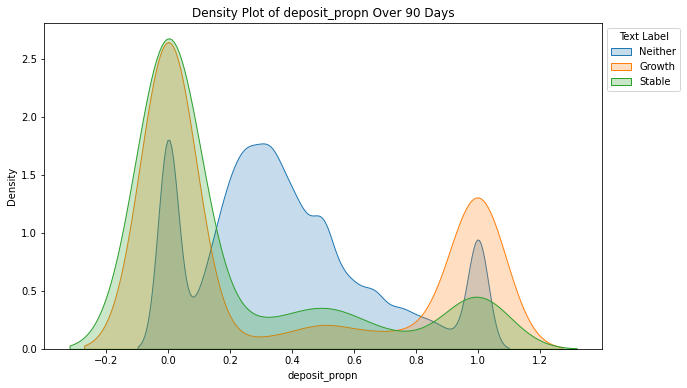

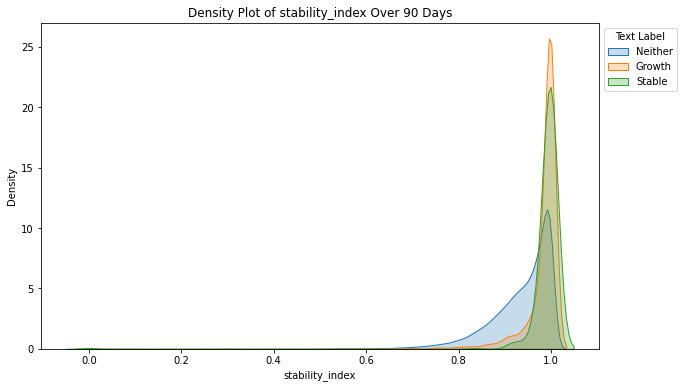

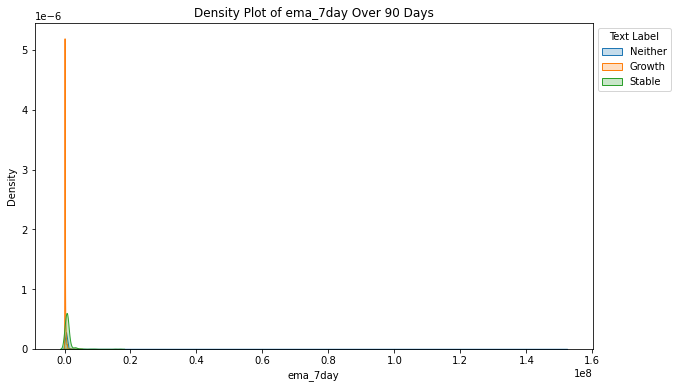

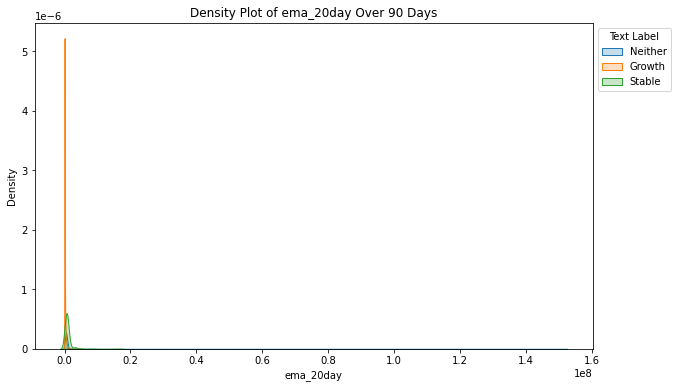

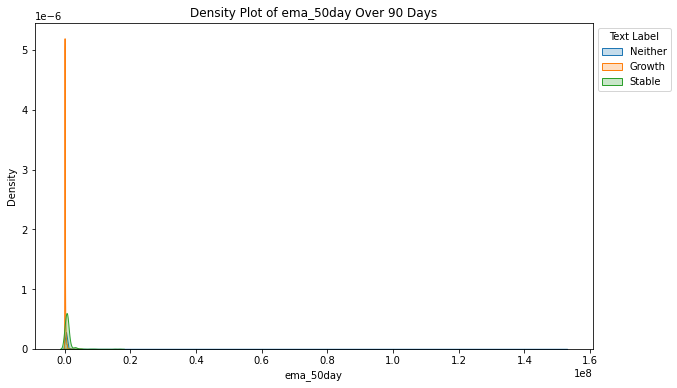

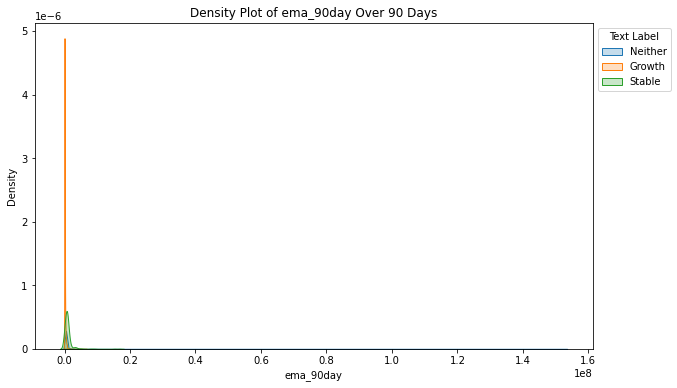

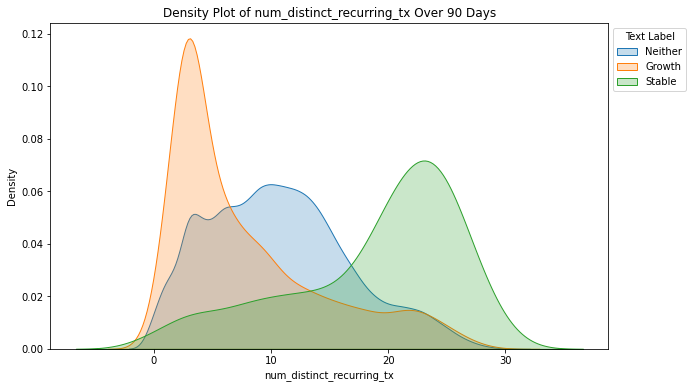

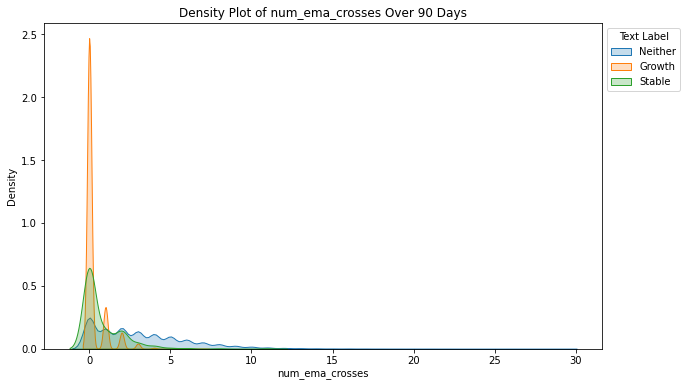

In [95]:
# Disable the spotlight effect in Jupyter Notebook
from IPython.display import display, HTML

display(HTML("<style>.rendered_html img {max-width:100%;}</style>"))

# Define the output folder and create it if it doesn't exist
output_folder = '/Users/tammichia/Desktop/capstone eda/EDA 90 DAYS - NEITHER:STABLE:GROWTH'
os.makedirs(output_folder, exist_ok=True)

# Create subsets of users
subsets = {}
for label in df['text_label'].unique():
    subsets[label] = df[df['text_label'] == label]

# Customize the plot
for feature in numerical_features:
    # Create a new figure for each plot
    plt.figure(figsize=(10, 6))
    
    for label, subset in subsets.items():
        sns.kdeplot(data=subset, x=feature, label=label, common_norm=False, fill=True)

    # Set the title and labels
    plt.title(f'Density Plot of {feature} Over 90 Days')
    plt.xlabel(f'{feature}')

    # Show the legend with "text_label" values
    plt.legend(title='Text Label', loc='upper left', bbox_to_anchor=(1, 1))
    
    filename = os.path.join(output_folder, f'{feature}_density_plots.jpg')
    plt.savefig(filename, bbox_inches='tight', format='jpg', dpi=300)
    
    # Show the plot (optional)
    plt.show()


### Categorical Features (neither vs. growth vs. stable)

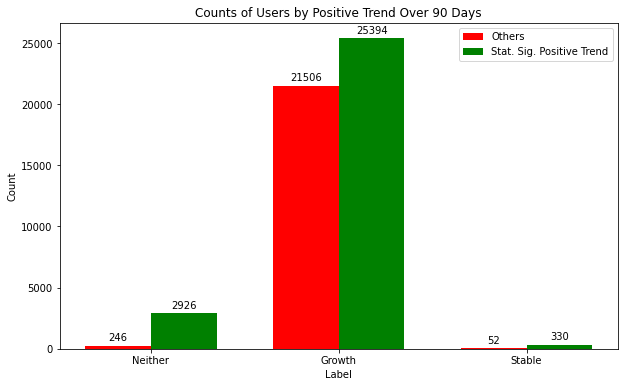

In [8]:
# Group the data by 'label' and 'stat_sig_positive_kendall', then count the occurrences
grouped_counts = df.groupby(['text_label', 'stat_sig_positive_kendall']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='Others')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Stat. Sig. Positive Trend')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Users by Positive Trend Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

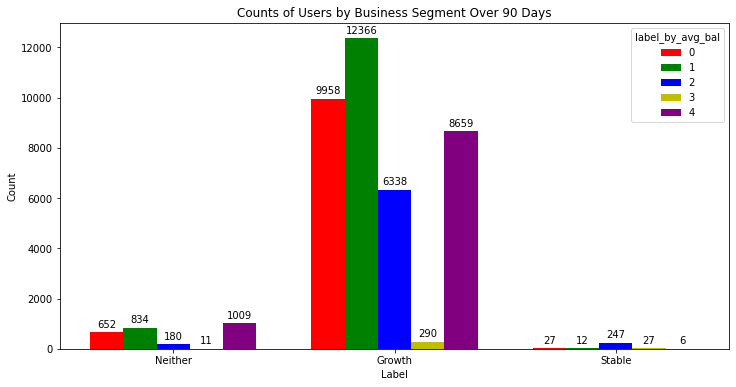

In [100]:
grouped_counts = df.groupby(['text_label', 'label_by_avg_bal']).size().unstack(fill_value=0).reset_index()

# Create a list of labels and the corresponding counts for '0', '1', '2', '3', and '4'
labels = df['text_label'].unique()
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]
counts_2 = grouped_counts[2]
counts_3 = grouped_counts[3]
counts_4 = grouped_counts[4]

# Determine the width of each bar and the number of bars
bar_width = 0.15  # Adjust the bar width to accommodate five bars
num_bars = len(labels)
index = np.arange(num_bars)

# Create the bar chart
plt.figure(figsize=(12, 6))

# Plot bars for '0', '1', '2', '3', and '4' with equal spacing
bar1 = plt.bar(index - 2*bar_width, counts_0, bar_width, color='r', label='0')
bar2 = plt.bar(index - bar_width, counts_1, bar_width, color='g', label='1')
bar3 = plt.bar(index, counts_2, bar_width, color='b', label='2')
bar4 = plt.bar(index + bar_width, counts_3, bar_width, color='y', label='3')
bar5 = plt.bar(index + 2*bar_width, counts_4, bar_width, color='purple', label='4')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Users by Business Segment Over 90 Days')
plt.xticks(index, labels)
plt.legend(title='label_by_avg_bal')

# Add count labels on top of each bar
for bars, counts in zip([bar1, bar2, bar3, bar4, bar5], [counts_0, counts_1, counts_2, counts_3, counts_4]):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.annotate(f'{int(count)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

# Show the plot
plt.show()


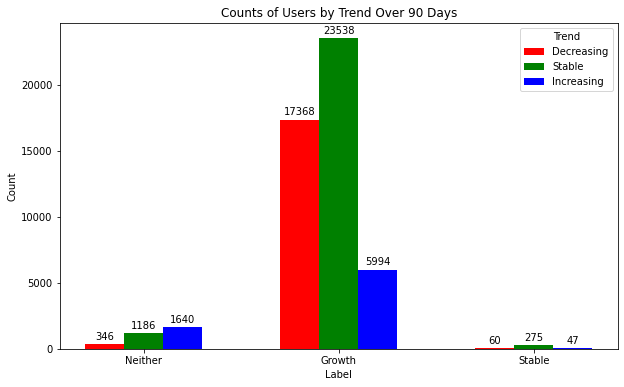

In [9]:
# Group the data by 'text_label' and 'trend', then count the occurrences
grouped_counts = df.groupby(['text_label', 'trend']).size().unstack(fill_value=0).reset_index()

# Create a list of labels and the corresponding counts for '0', '1', and '2'
labels = df['text_label'].unique()
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]
counts_2 = grouped_counts[2]

# Determine the width of each bar and the number of bars
bar_width = 0.2
num_bars = len(labels)
index = np.arange(num_bars)

# Create the bar chart
plt.figure(figsize=(10, 6))

# Plot bars for '0', '1', and '2' with equal spacing
bar1 = plt.bar(index - bar_width, counts_0, bar_width, color='r', label='Decreasing')
bar2 = plt.bar(index, counts_1, bar_width, color='g', label='Stable')
bar3 = plt.bar(index + bar_width, counts_2, bar_width, color='b', label='Increasing')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Users by Trend Over 90 Days')
plt.xticks(index, labels)
plt.legend(title='Trend')

# Add count labels on top of each bar
for bars, counts in zip([bar1, bar2, bar3], [counts_0, counts_1, counts_2]):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.annotate(f'{int(count)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

# Show the plot
plt.show()


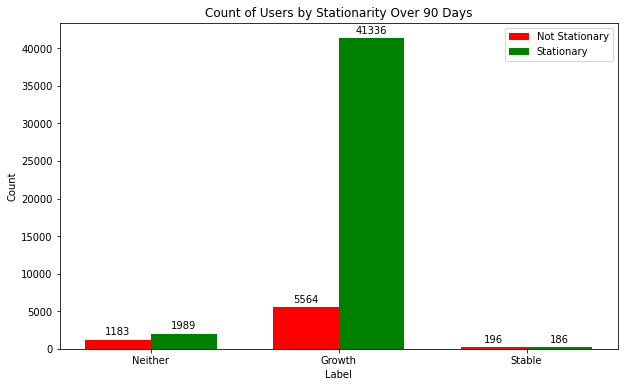

In [10]:
grouped_counts = df.groupby(['text_label', 'stationary']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='Not Stationary')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Stationary')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Users by Stationarity Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

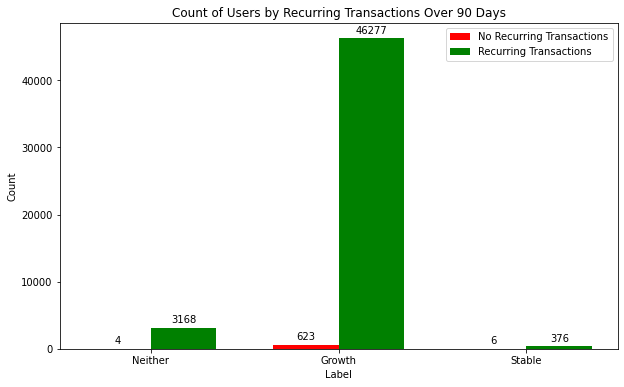

In [12]:
grouped_counts = df.groupby(['text_label', 'recurring_transactions']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='No Recurring Transactions')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Recurring Transactions')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Users by Recurring Transactions Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

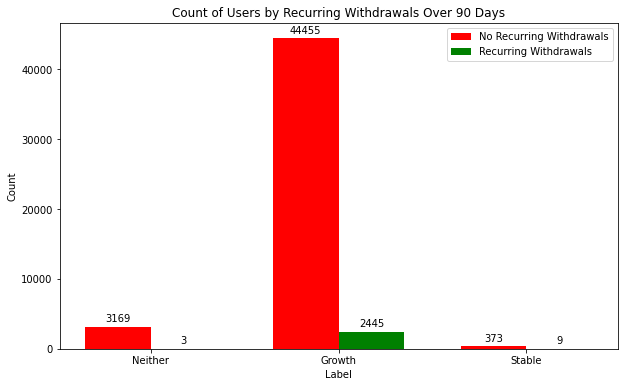

In [13]:
grouped_counts = df.groupby(['text_label', 'recurring_withdrawals']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='No Recurring Withdrawals')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Recurring Withdrawals')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Users by Recurring Withdrawals Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

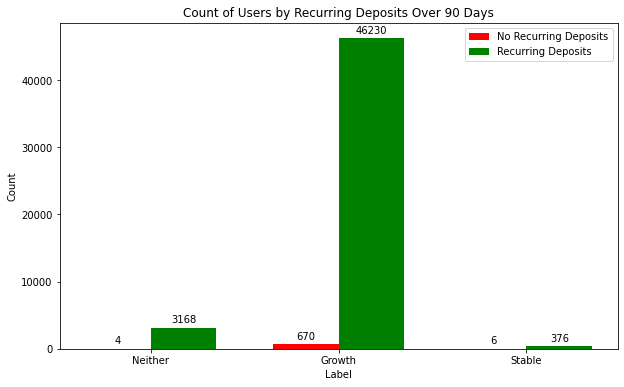

In [15]:
grouped_counts = df.groupby(['text_label', 'recurring_deposits']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='No Recurring Deposits')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Recurring Deposits')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Users by Recurring Deposits Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

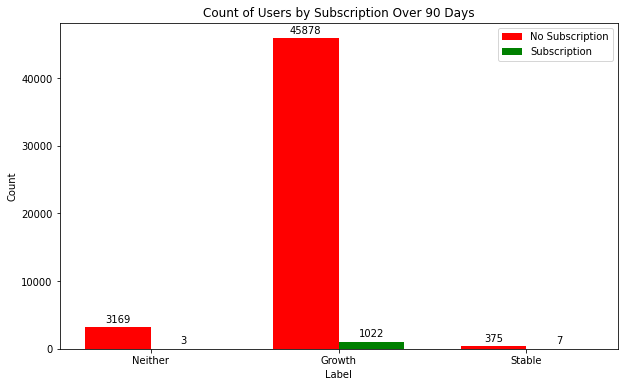

In [17]:
grouped_counts = df.groupby(['text_label', 'subscription']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='No Subscription')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Subscription')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Users by Subscription Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

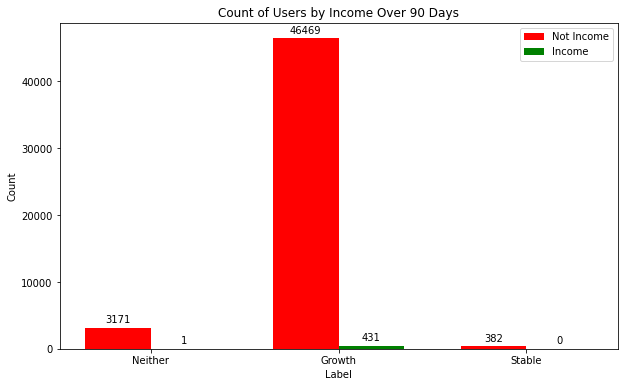

In [84]:
grouped_counts = df.groupby(['text_label', 'income']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='Not Income')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Income')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Users by Income Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

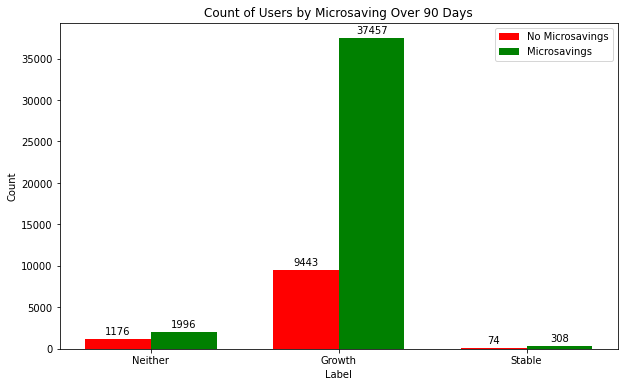

In [18]:
grouped_counts = df.groupby(['text_label', 'micro_savings']).size().unstack(fill_value=0).reset_index()
grouped_counts.columns

# Create a list of labels and the corresponding counts for '0' and '1'
labels = df['text_label'].unique()  
counts_0 = grouped_counts[0]
counts_1 = grouped_counts[1]

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels))

# Create the bar chart
plt.figure(figsize=(10, 6))  

# Plot bars for '0' and '1'
bar1 = plt.bar(index, counts_0, bar_width, align='center', color='r', label='No Microsavings')
bar2 = plt.bar([i + bar_width for i in index], counts_1, bar_width, align='center', color='g', label='Microsavings')

# Customize the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Users by Microsaving Over 90 Days')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()

# Add count labels on top of each bar
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()

We also generated plots comparing "neither" vs. "growth" and "neither" vs. "stable" to provide the team with a clear visualization of which features are most relevant for the growth and stable classification models respectively.

### Numerical Features (neither vs. growth and neither vs. stable)

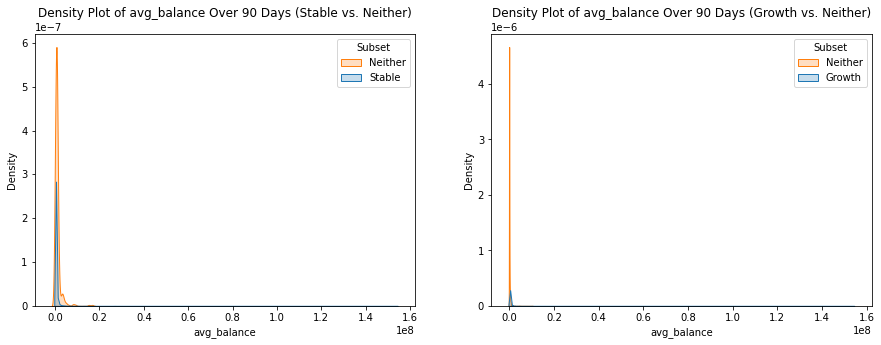

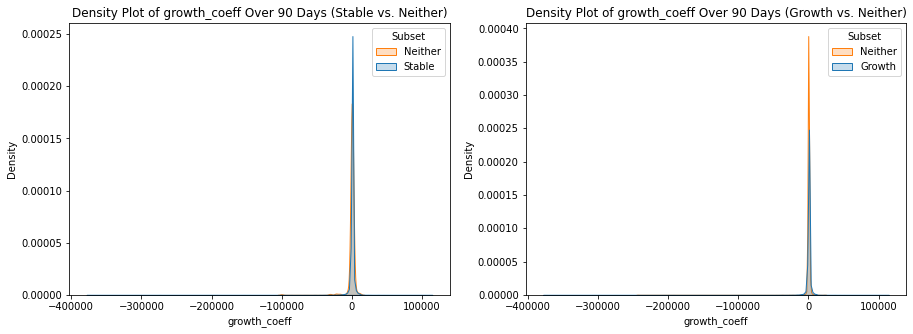

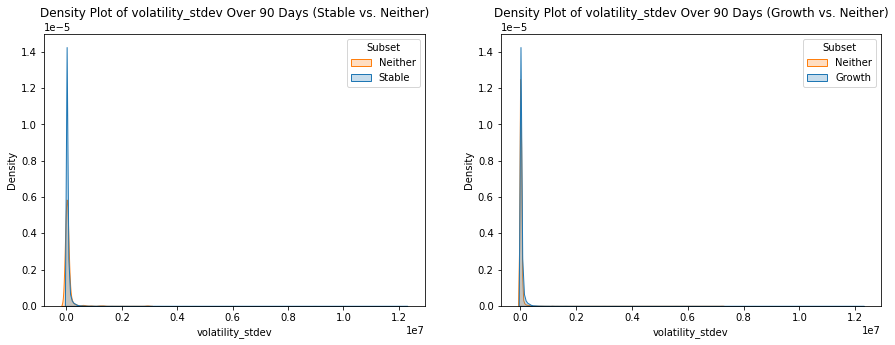

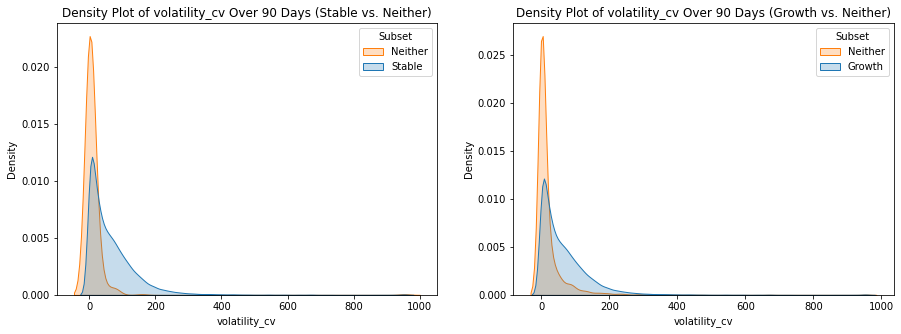

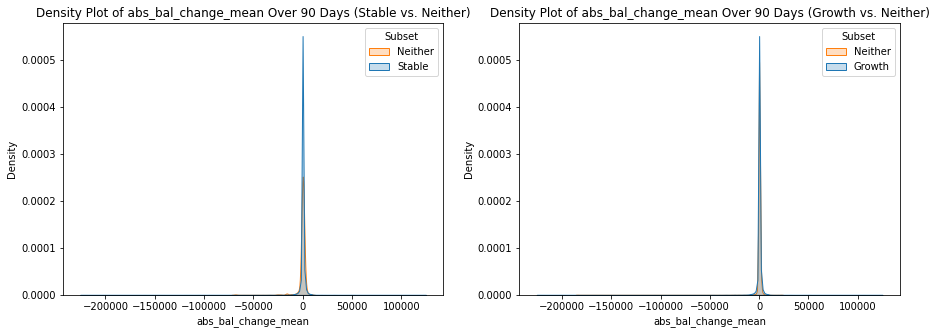

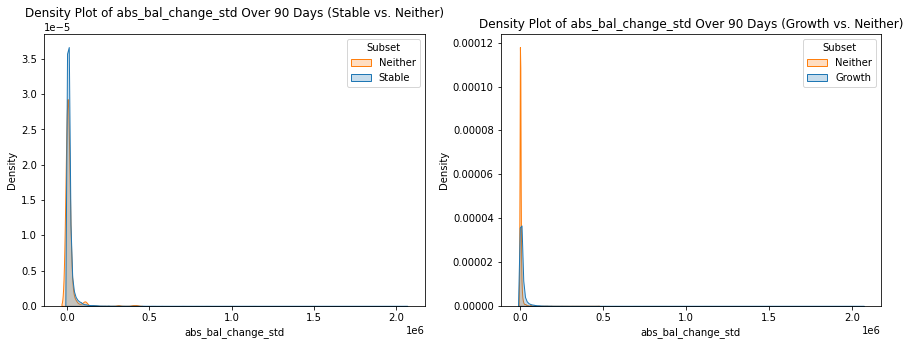

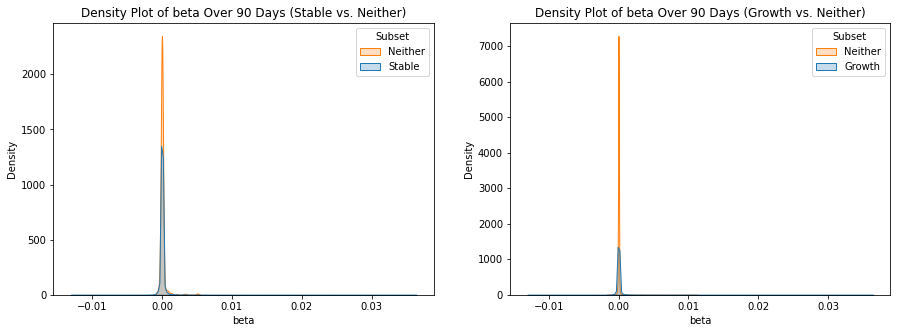

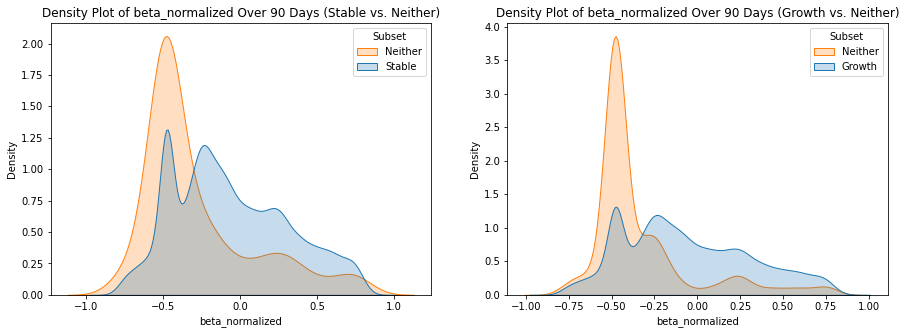

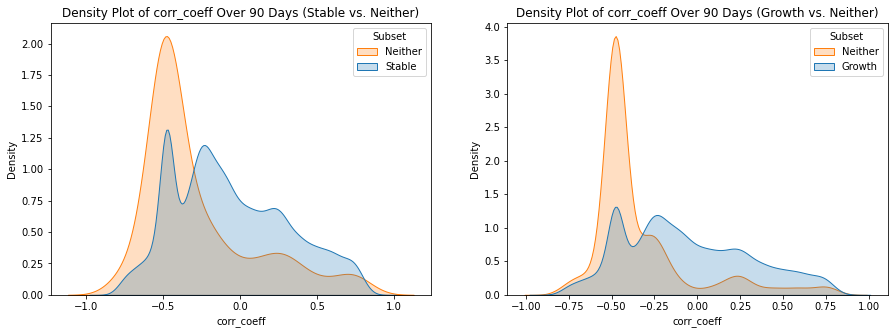

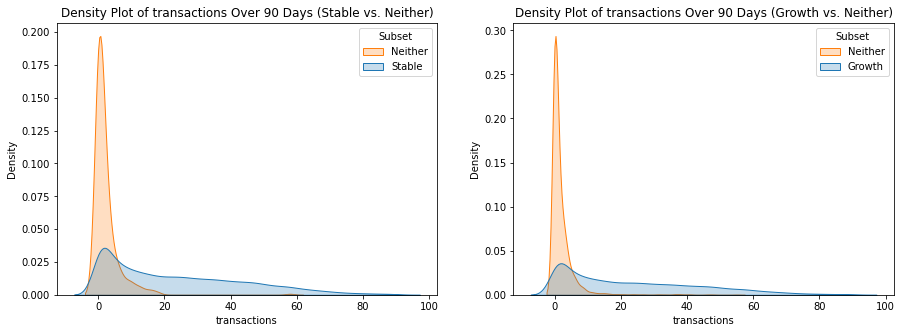

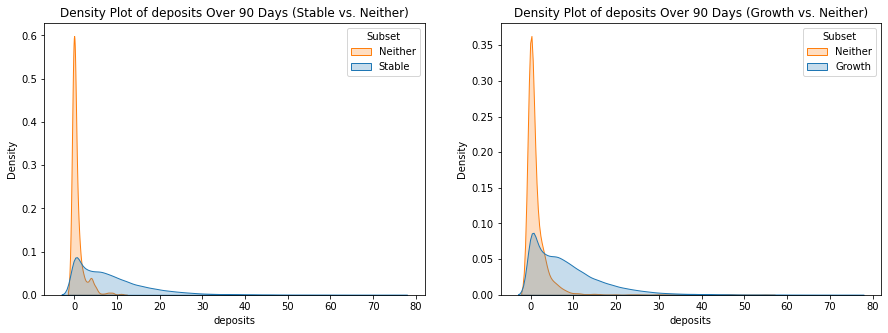

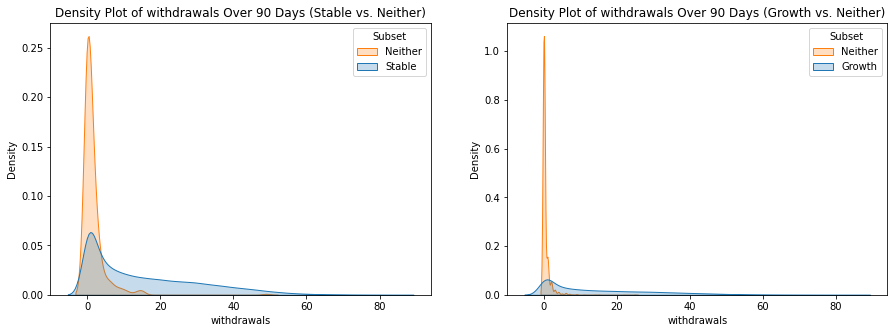

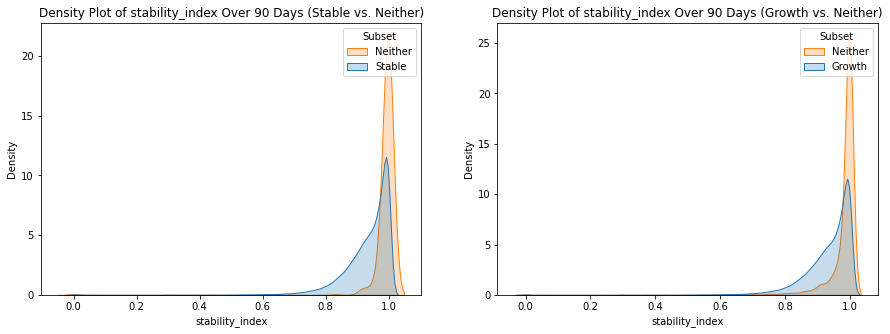

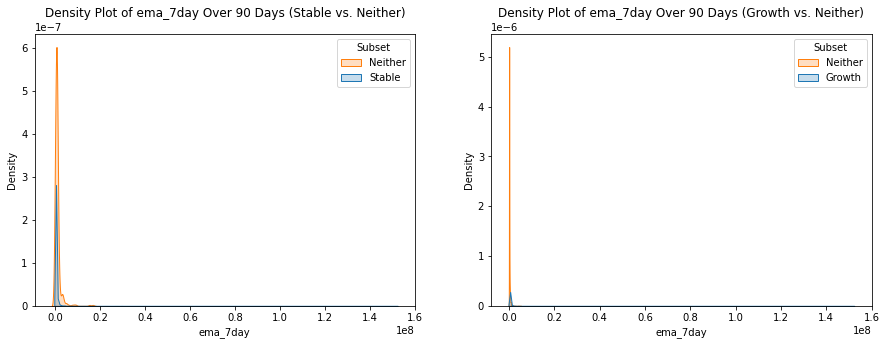

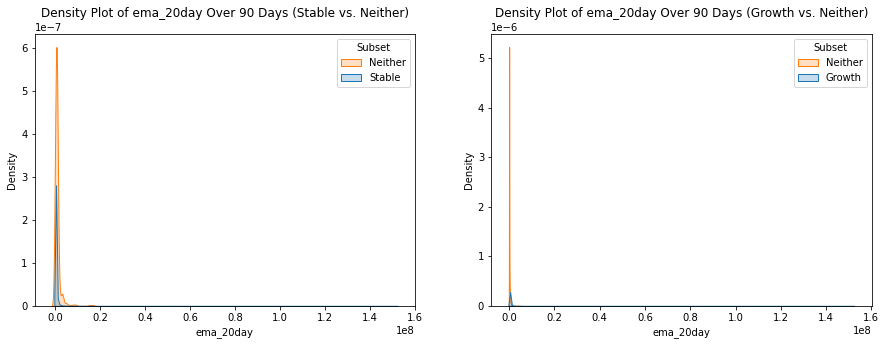

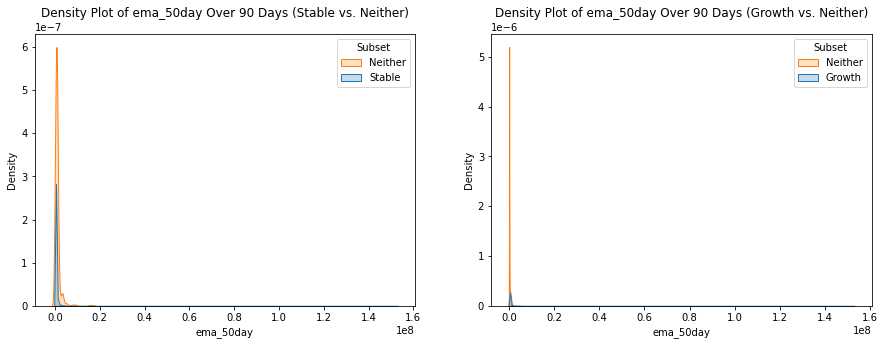

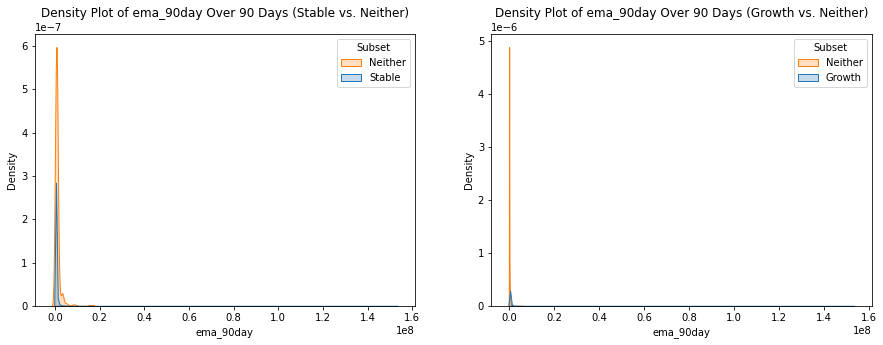

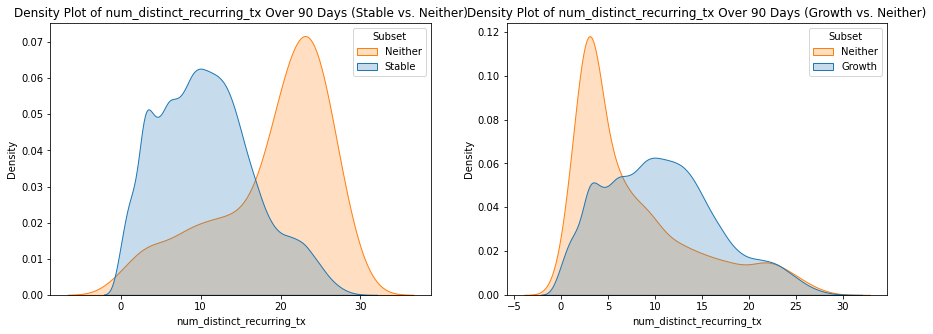

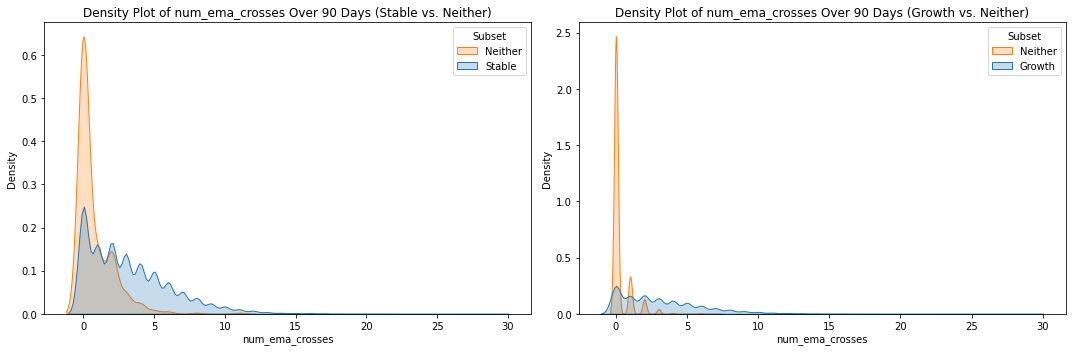

In [26]:
# Create subsets of users
subset_neither_stable = df[(df['text_label'] == 'Neither') | (df['text_label'] == 'Stable')]
subset_neither_growth = df[(df['text_label'] == 'Neither') | (df['text_label'] == 'Growth')]

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

for var in numerical_features:
    # Plot for Neither vs. Stable
    sns.kdeplot(data=subset_neither_stable, x=var, hue='text_label', common_norm=False, fill=True, ax=axes[0])
    axes[0].set_title(f'Density Plot of {var} Over 90 Days (Stable vs. Neither)')
    axes[0].set_xlabel(var)
    axes[0].legend(title='Subset', labels=['Neither', 'Stable'])
    
    # Plot for Neither vs. Growth
    sns.kdeplot(data=subset_neither_growth, x=var, hue='text_label', common_norm=False, fill=True, ax=axes[1])
    axes[1].set_title(f'Density Plot of {var} Over 90 Days (Growth vs. Neither)')
    axes[1].set_xlabel(var)
    axes[1].legend(title='Subset', labels=['Neither', 'Growth'])

    # Create a new set of subplots for the next variable
    if var != numerical_features[-1]:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

### Categorical Features (neither vs. growth and neither vs. stable)

In [10]:
import pandas as pd

# Assuming you have a DataFrame df with 'text_label' and 'trend' columns

# Filter the data for each 'text_label' category
neither_data = df[df['text_label'] == 'Neither']
growth_data = df[df['text_label'] == 'Growth']
stable_data = df[df['text_label'] == 'Stable']

# Calculate the percentage distribution for each 'text_label' category and trend value (0, 1, 2)
def calculate_percentage_distribution(data):
    total_counts = data['trend'].value_counts().sort_index()
    percentage_distribution = (total_counts / total_counts.sum() * 100).round(2)
    return percentage_distribution

neither_percentage = calculate_percentage_distribution(neither_data)
growth_percentage = calculate_percentage_distribution(growth_data)
stable_percentage = calculate_percentage_distribution(stable_data)

# Create a DataFrame to display the results
percentage_table = pd.DataFrame({
    'Category': ['Neither', 'Growth', 'Stable'],
    'Trend 0 (%)': [neither_percentage[0], growth_percentage[0], stable_percentage[0]],
    'Trend 1 (%)': [neither_percentage[1], growth_percentage[1], stable_percentage[1]],
    'Trend 2 (%)': [neither_percentage[2], growth_percentage[2], stable_percentage[2]]
})

# Display the percentage distribution table
print(percentage_table)


  Category  Trend 0 (%)  Trend 1 (%)  Trend 2 (%)
0  Neither        37.03        50.19        12.78
1   Growth        10.91        37.39        51.70
2   Stable        15.71        71.99        12.30


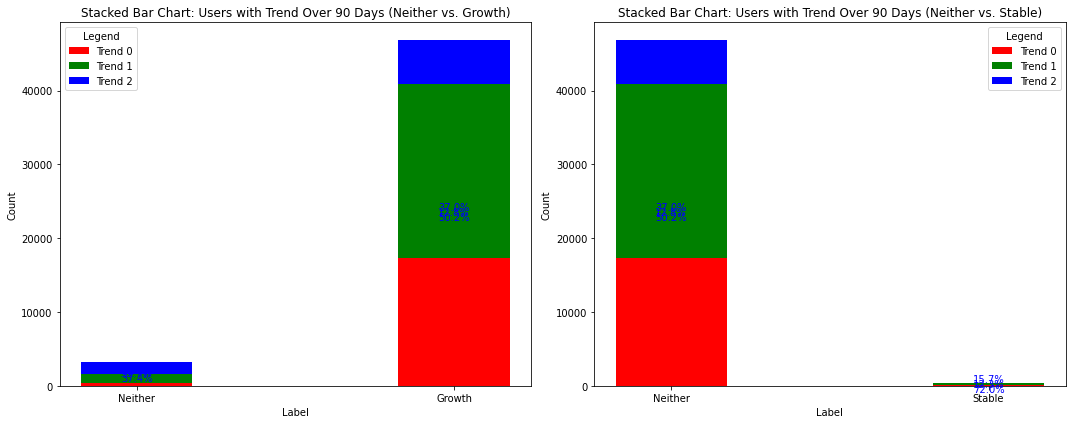

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'trend', then count the occurrences
grouped_counts = df.groupby(['text_label', 'trend']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage labels to the bars
def add_percentage_labels(ax, counts_0, counts_1, counts_2):
    total = [count_0 + count_1 + count_2 for count_0, count_1, count_2 in zip(counts_0, counts_1, counts_2)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]
    percentages_2 = [(count_2 / t) * 100 if t != 0 else 0 for count_2, t in zip(counts_2, total)]

    for i, (p0, p1, p2) in enumerate(zip(percentages_0, percentages_1, percentages_2)):
        height = max(counts_0[i], counts_1[i], counts_2[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')
            ax.annotate(f'{p2:.1f}%', (i, height), ha='center', va='center', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])
counts_neither_growth_2 = list(subset_neither_growth[2])

# Plot the stacked bar chart for "Neither vs. Growth" and 'trend'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='Trend 0')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Trend 1', bottom=counts_neither_growth_0)
axes[0].bar(index, counts_neither_growth_2, bar_width, align='center', color='b', label='Trend 2', bottom=[i + j for i, j in zip(counts_neither_growth_0, counts_neither_growth_1)])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Trend Over 90 Days (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[0], counts_neither_growth_0, counts_neither_growth_1, counts_neither_growth_2)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])
counts_neither_stable_2 = list(subset_neither_stable[2])

# Plot the stacked bar chart for "Neither vs. Stable" and 'trend'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='Trend 0')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Trend 1', bottom=counts_neither_stable_0)
axes[1].bar(index, counts_neither_stable_2, bar_width, align='center', color='b', label='Trend 2', bottom=[i + j for i, j in zip(counts_neither_stable_0, counts_neither_stable_1)])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Trend Over 90 Days (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[1], counts_neither_stable_0, counts_neither_stable_1, counts_neither_stable_2)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


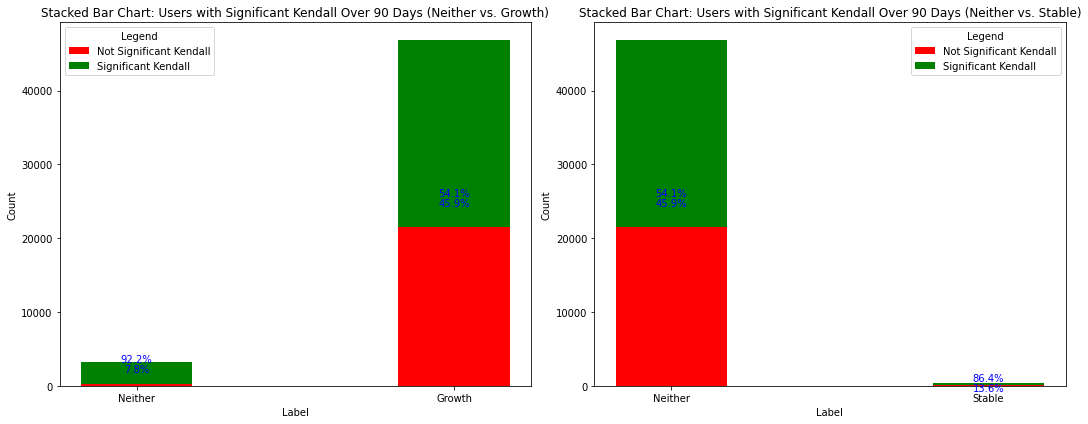

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'stat_sig_positive_kendall', then count the occurrences
grouped_counts = df.groupby(['text_label', 'stat_sig_positive_kendall']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage labels to the bars
def add_percentage_labels(ax, counts_0, counts_1):
    total = [count_0 + count_1 for count_0, count_1 in zip(counts_0, counts_1)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]

    for i, (p0, p1) in enumerate(zip(percentages_0, percentages_1)):
        height = max(counts_0[i], counts_1[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])

# Plot the stacked bar chart for "Neither vs. Growth" and 'stat_sig_positive_kendall'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='Not Significant Kendall')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Significant Kendall', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Significant Kendall Over 90 Days (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[0], counts_neither_growth_1, counts_neither_growth_0)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])

# Plot the stacked bar chart for "Neither vs. Stable" and 'stat_sig_positive_kendall'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='Not Significant Kendall')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Significant Kendall', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Significant Kendall Over 90 Days (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[1], counts_neither_stable_1, counts_neither_stable_0)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


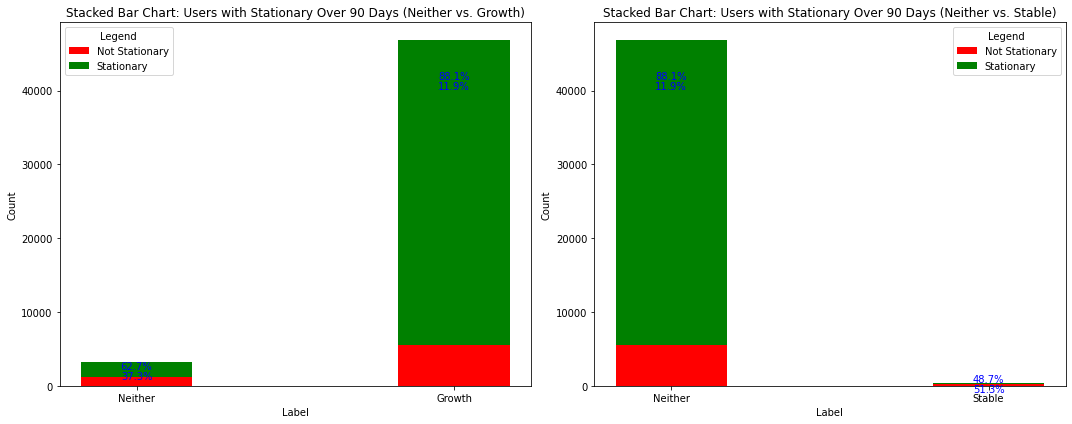

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'stationary', then count the occurrences
grouped_counts = df.groupby(['text_label', 'stationary']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage labels to the bars
def add_percentage_labels(ax, counts_0, counts_1):
    total = [count_0 + count_1 for count_0, count_1 in zip(counts_0, counts_1)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]

    for i, (p0, p1) in enumerate(zip(percentages_0, percentages_1)):
        height = max(counts_0[i], counts_1[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])

# Plot the stacked bar chart for "Neither vs. Growth" and 'stationary'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='Not Stationary')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Stationary', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Stationary Over 90 Days (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[0], counts_neither_growth_1, counts_neither_growth_0)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])

# Plot the stacked bar chart for "Neither vs. Stable" and 'stationary'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='Not Stationary')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Stationary', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Stationary Over 90 Days (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[1], counts_neither_stable_1, counts_neither_stable_0)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


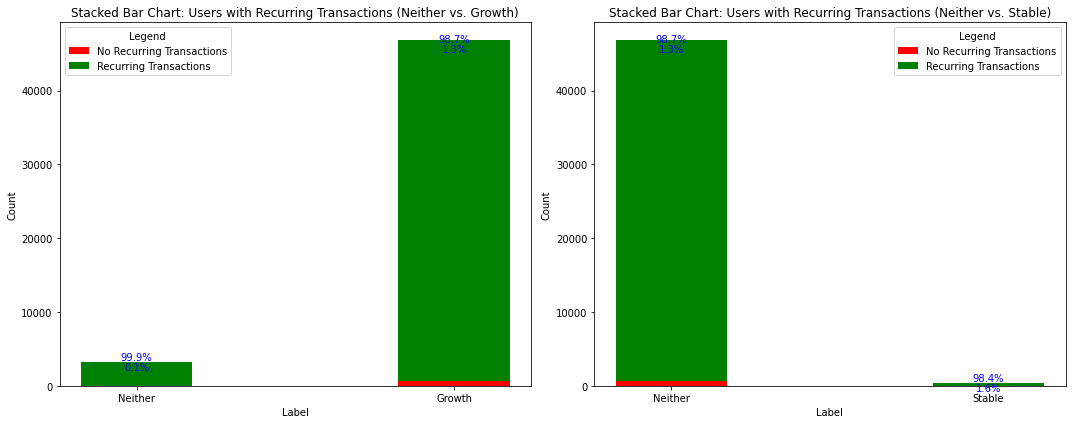

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'recurring_transactions', then count the occurrences
grouped_counts = df.groupby(['text_label', 'recurring_transactions']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage labels to the bars
def add_percentage_labels(ax, counts_0, counts_1):
    total = [count_0 + count_1 for count_0, count_1 in zip(counts_0, counts_1)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]

    for i, (p0, p1) in enumerate(zip(percentages_0, percentages_1)):
        height = max(counts_0[i], counts_1[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])

# Plot the stacked bar chart for "Neither vs. Growth" and 'recurring_transactions'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='No Recurring Transactions')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Recurring Transactions', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Recurring Transactions (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[0], counts_neither_growth_1, counts_neither_growth_0)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])

# Plot the stacked bar chart for "Neither vs. Stable" and 'recurring_transactions'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='No Recurring Transactions')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Recurring Transactions', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Recurring Transactions (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[1], counts_neither_stable_1, counts_neither_stable_0)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


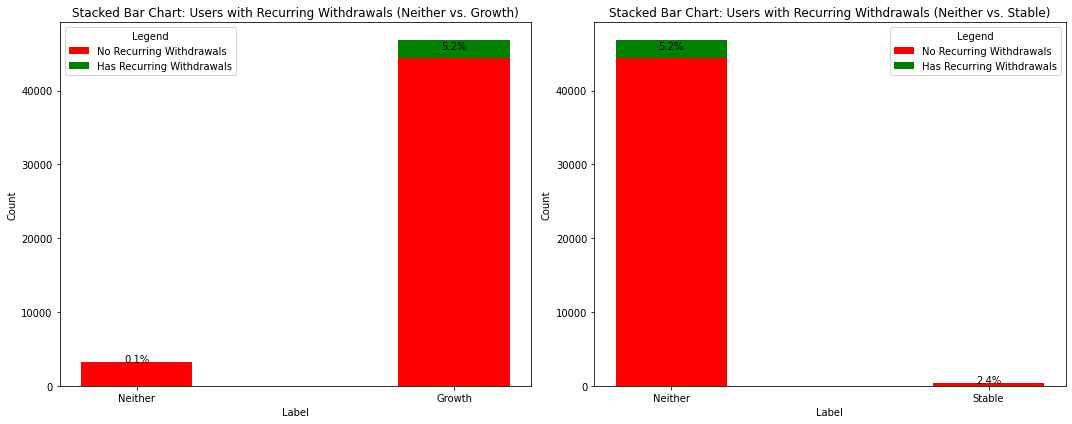

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'recurring_withdrawals', then count the occurrences
grouped_counts = df.groupby(['text_label', 'recurring_withdrawals']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage arrows to the bars
def add_percentage_arrow(ax, count, total, xpos, ypos):
    percentage = count / total * 100
    ax.annotate(f'{percentage:.1f}%', (xpos, ypos), ha='center')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = subset_neither_growth[0]
counts_neither_growth_1 = subset_neither_growth[1]

# Plot the stacked bar chart for "Neither vs. Growth" and 'recurring_withdrawals'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='No Recurring Withdrawals')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Has Recurring Withdrawals', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Recurring Withdrawals (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage arrows to the bars for "Neither vs. Growth"
for i, (count_0, count_1) in enumerate(zip(counts_neither_growth_0, counts_neither_growth_1)):
    total = count_0 + count_1
    add_percentage_arrow(axes[0], count_1, total, i, total - count_1 / 2)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = subset_neither_stable[0]
counts_neither_stable_1 = subset_neither_stable[1]

# Plot the stacked bar chart for "Neither vs. Stable" and 'recurring_withdrawals'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='No Recurring Withdrawals')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Has Recurring Withdrawals', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Recurring Withdrawals (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage arrows to the bars for "Neither vs. Stable"
for i, (count_0, count_1) in enumerate(zip(counts_neither_stable_0, counts_neither_stable_1)):
    total = count_0 + count_1
    add_percentage_arrow(axes[1], count_1, total, i, total - count_1 / 2)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


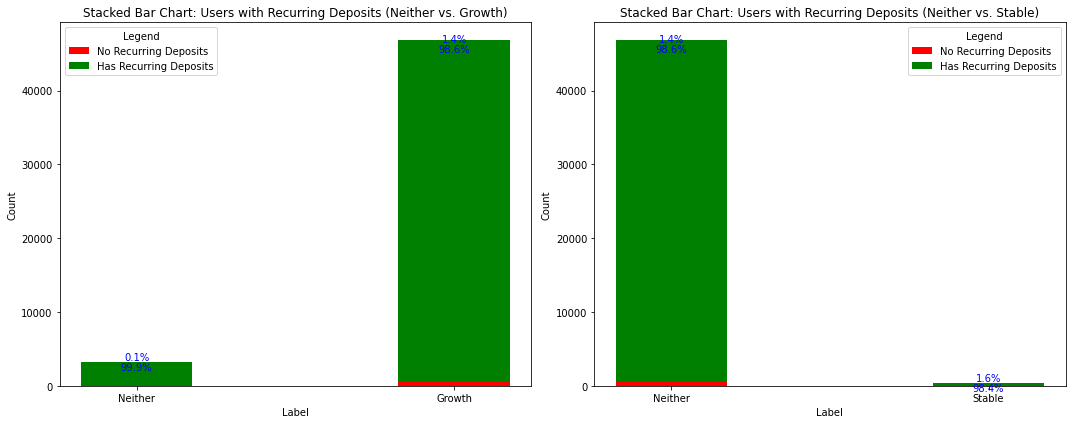

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'recurring_deposits', then count the occurrences
grouped_counts = df.groupby(['text_label', 'recurring_deposits']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage labels to the bars
def add_percentage_labels(ax, counts_0, counts_1):
    total = [count_0 + count_1 for count_0, count_1 in zip(counts_0, counts_1)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]

    for i, (p0, p1) in enumerate(zip(percentages_0, percentages_1)):
        height = max(counts_0[i], counts_1[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])

# Plot the stacked bar chart for "Neither vs. Growth" and 'recurring_deposits'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='No Recurring Deposits')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Has Recurring Deposits', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Recurring Deposits (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[0], counts_neither_growth_0, counts_neither_growth_1)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])

# Plot the stacked bar chart for "Neither vs. Stable" and 'recurring_deposits'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='No Recurring Deposits')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Has Recurring Deposits', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Recurring Deposits (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[1], counts_neither_stable_0, counts_neither_stable_1)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


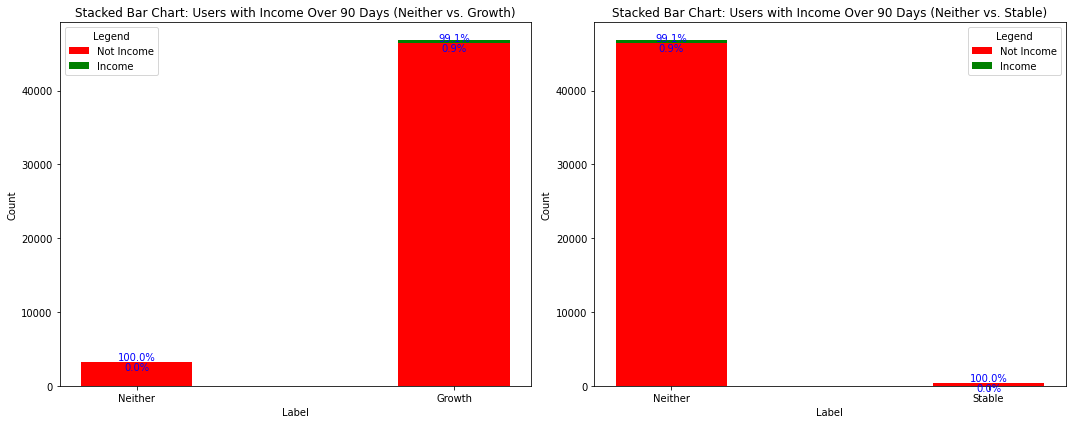

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'income', then count the occurrences
grouped_counts = df.groupby(['text_label', 'income']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage labels to the bars
def add_percentage_labels(ax, counts_0, counts_1):
    total = [count_0 + count_1 for count_0, count_1 in zip(counts_0, counts_1)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]

    for i, (p0, p1) in enumerate(zip(percentages_0, percentages_1)):
        height = max(counts_0[i], counts_1[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])

# Plot the stacked bar chart for "Neither vs. Growth" and 'income'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='Not Income')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Income', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Income Over 90 Days (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[0], counts_neither_growth_0, counts_neither_growth_1)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])

# Plot the stacked bar chart for "Neither vs. Stable" and 'income'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='Not Income')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Income', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Income Over 90 Days (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[1], counts_neither_stable_0, counts_neither_stable_1)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


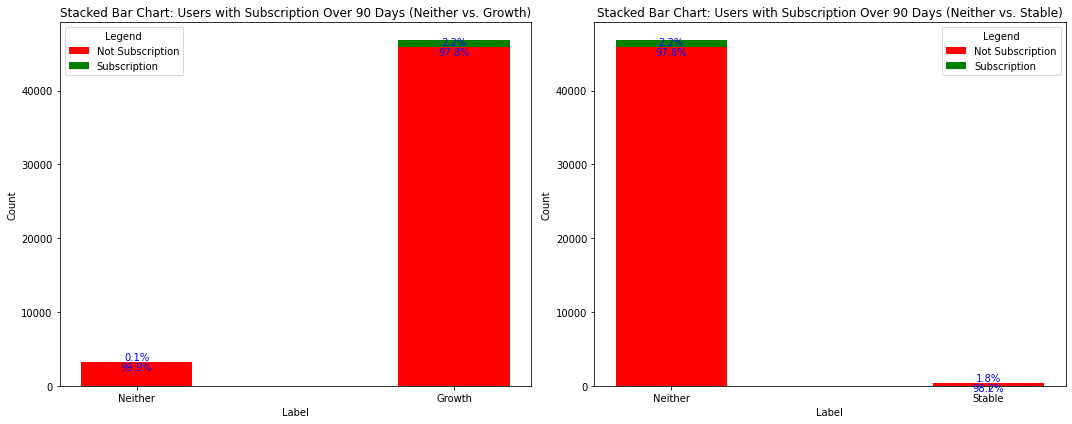

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'subscription', then count the occurrences
grouped_counts = df.groupby(['text_label', 'subscription']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentages to the bars on both sides
def add_percentages(ax, counts_0, counts_1):
    total = [count_0 + count_1 for count_0, count_1 in zip(counts_0, counts_1)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]

    for i, (p0, p1) in enumerate(zip(percentages_0, percentages_1)):
        height = max(counts_0[i], counts_1[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])

# Plot the stacked bar chart for "Neither vs. Growth"
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='Not Subscription')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Subscription', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Subscription Over 90 Days (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentages to the bars on both sides
add_percentages(axes[0], counts_neither_growth_1, counts_neither_growth_0)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])

# Plot the stacked bar chart for "Neither vs. Stable"
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='Not Subscription')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Subscription', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Subscription Over 90 Days (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentages to the bars on both sides
add_percentages(axes[1], counts_neither_stable_1, counts_neither_stable_0)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

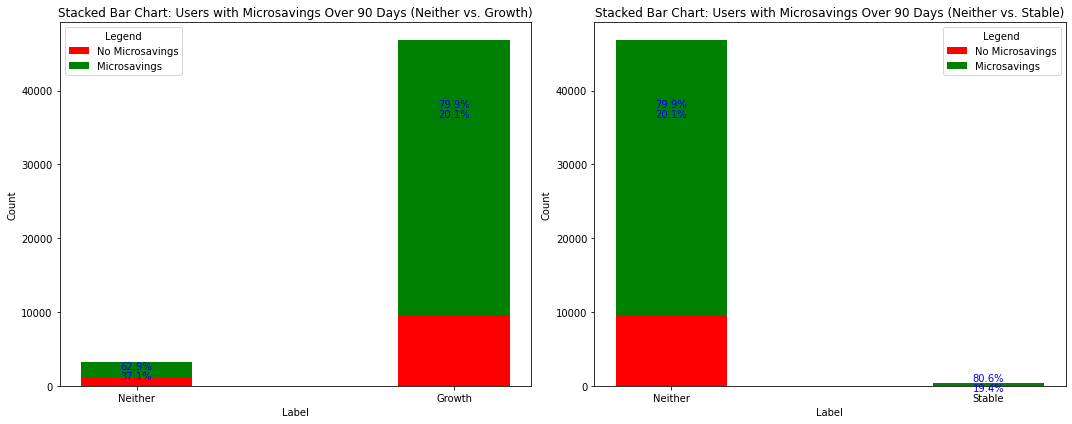

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'text_label' and 'micro_savings', then count the occurrences
grouped_counts = df.groupby(['text_label', 'micro_savings']).size().unstack(fill_value=0).reset_index()

# Determine the unique labels for the specific comparisons you want
labels_growth = ['Neither', 'Growth']
labels_stable = ['Neither', 'Stable']

# Determine the width of each bar
bar_width = 0.35
index = range(len(labels_growth))

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Function to add percentage labels to the bars
def add_percentage_labels(ax, counts_0, counts_1):
    total = [count_0 + count_1 for count_0, count_1 in zip(counts_0, counts_1)]
    percentages_0 = [(count_0 / t) * 100 if t != 0 else 0 for count_0, t in zip(counts_0, total)]
    percentages_1 = [(count_1 / t) * 100 if t != 0 else 0 for count_1, t in zip(counts_1, total)]

    for i, (p0, p1) in enumerate(zip(percentages_0, percentages_1)):
        height = max(counts_0[i], counts_1[i])  # Determine the maximum height
        if height > 0:
            ax.annotate(f'{p0:.1f}%', (i, height), ha='center', va='bottom', color='b')
            ax.annotate(f'{p1:.1f}%', (i, height), ha='center', va='top', color='b')

# Filter data for "Neither vs. Growth"
subset_neither_growth = grouped_counts[grouped_counts['text_label'].isin(labels_growth)]
labels_neither_growth = subset_neither_growth['text_label']
counts_neither_growth_0 = list(subset_neither_growth[0])
counts_neither_growth_1 = list(subset_neither_growth[1])

# Plot the stacked bar chart for "Neither vs. Growth" and 'micro_savings'
axes[0].bar(index, counts_neither_growth_0, bar_width, align='center', color='r', label='No Microsavings')
axes[0].bar(index, counts_neither_growth_1, bar_width, align='center', color='g', label='Microsavings', bottom=counts_neither_growth_0)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart: Users with Microsavings Over 90 Days (Neither vs. Growth)')
axes[0].set_xticks(index)
axes[0].set_xticklabels(labels_growth)
axes[0].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[0], counts_neither_growth_1, counts_neither_growth_0)

# Filter data for "Neither vs. Stable"
subset_neither_stable = grouped_counts[grouped_counts['text_label'].isin(labels_stable)]
labels_neither_stable = subset_neither_stable['text_label']
counts_neither_stable_0 = list(subset_neither_stable[0])
counts_neither_stable_1 = list(subset_neither_stable[1])

# Plot the stacked bar chart for "Neither vs. Stable" and 'micro_savings'
axes[1].bar(index, counts_neither_stable_0, bar_width, align='center', color='r', label='No Microsavings')
axes[1].bar(index, counts_neither_stable_1, bar_width, align='center', color='g', label='Microsavings', bottom=counts_neither_stable_0)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart: Users with Microsavings Over 90 Days (Neither vs. Stable)')
axes[1].set_xticks(index)
axes[1].set_xticklabels(labels_stable)
axes[1].legend(title='Legend')

# Add percentage labels to the bars
add_percentage_labels(axes[1], counts_neither_stable_1, counts_neither_stable_0)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()
